In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
#from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python.utils import natural_keys, label_figure, convert_range

from matplotlib.lines import Line2D




/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
%matplotlib notebook

# Set color schemes by visual area

In [3]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Set dataset parameters

In [4]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)



... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [5]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])

filter_by = 'drop_repeats'
data_id = '%s|%s' % (data_id, filter_by)
print(data_id)


traces001|fit-2dgaus_dff-no-cutoff-thr-0.50|drop_repeats


# Set output dir

In [87]:
genstats_dir = os.path.join(outdir, 'general-stats', '%s' %filter_by)
if not os.path.exists(genstats_dir):
    os.makedirs(genstats_dir)
print(genstats_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats


# Load data

In [6]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [31]:
reload(rfutils)
reload(fitrf)
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [478]:
scale_sigma = False
reliable_only = True
reliable_str = 'reliable' if reliable_only else ''

filter_str = '%s_%s' % (filter_by, reliable_str)
print(filter_str)

#### Get non-repeated FOV datasets
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                  traceid=traceid, fit_desc=fit_desc,
                                                  reliable_only=reliable_only, verbose=False,
                                                  #scale_sigma=scale_sigma, 
                                                  fov_type=fov_type, state=state, stimulus='rfs')

#### Split fx, fy for theta comp
r_df['fx'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.cos(r_df['theta']))
r_df['fy'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.sin(r_df['theta']))
r_df['ratio_xy'] = r_df['std_x']/r_df['std_y']

# Convert thetas to [-90, 90]
thetas = [(t % np.pi) - np.pi if ((np.pi/2.)<t<(np.pi) or (((3./2)*np.pi)<t<2*np.pi)) \
          else (t % np.pi) for t in r_df['theta'].values]
r_df['theta_c'] = thetas


drop_repeats_reliable
droppin repeats
[filter_by=drop_repeats] Excluding 24 total repeats
Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4


In [33]:
r_df.groupby(['visual_area', 'experiment']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  \
visual_area experiment                                                         
Li          rfs          46      46      46     46   46   46        46    46   
            rfs10       435     435     435    435  435  435       435   435   
Lm          rfs         197     197     197    197  197  197       197   197   
            rfs10       181     181     181    181  181  181       181   181   
V1          rfs         558     558     558    558  558  558       558   558   
            rfs10       540     540     540    540  540  540       540   540   

                        datakey  fovnum  session  std_x  std_y  fwhm_avg  \
visual_area experiment                                                     
Li          rfs              46      46       46     46     46        46   
            rfs10           435     435      435    435    435       435   
Lm          rfs             197     197      197    197    197       197   
            rfs10           181     181      181    181    181       181   
V1          rfs             558     558      558    558    558       558   
            rfs10           540     540      540    540    540       540   

                        std_avg  area  datakey_ix  
visual_area experiment                             
Li          rfs              46    46          46  
            rfs10           435   435         435  
Lm          rfs             197   197         197  
            rfs10           181   181         181  
V1          rfs             558   558         558  
            rfs10           540   540         540

In [ ]:
show_means = False

curr_metric = 'std_avg'
multi_comp_test = 'fdr_bh' #'holm'
mean_metric = 'mean' # median
groupby = 'datakey'
plot_str = 'show-mean' if show_means else 'show-cells'
mean_str = '%s-by-%s' % (mean_metric, groupby) if groupby is not None else mean_metric


In [517]:
expdf.groupby(['visual_area']).mean()

r2     fwhm_x     fwhm_y     theta         x0        y0  \
visual_area                                                                  
Li           0.674518  35.083593  25.586737  1.918542   7.797714  3.000996   
Lm           0.646720  26.465937  19.060428  3.080885  21.685671  0.748210   
V1           0.658178  23.015027  19.225660  3.016918  25.055064 -5.025836   

                   cell  fovnum      std_x      std_y   fwhm_avg    std_avg  \
visual_area                                                                   
Li           165.463415     1.0  14.929188  10.887973  30.335165  12.908581   
Lm           129.673684     1.0  11.262101   8.110821  22.763183   9.686461   
V1           147.003683     1.0   9.793629   8.181132  21.120343   8.987380   

                   area  datakey_ix         fx        fy  ratio_xy   theta_c  
visual_area                                                                   
Li           526.971640    2.390244  13.738742  5.446756  1.436559  0.156185  
Lm           305.215214    4.205263  10.277784  4.012972  1.494240 -0.011103  
V1           260.553983    3.744015   8.820739  3.939219  1.280821 -0.003176

# Size (rfs v rfs10

<IPython.core.display.Javascript object>


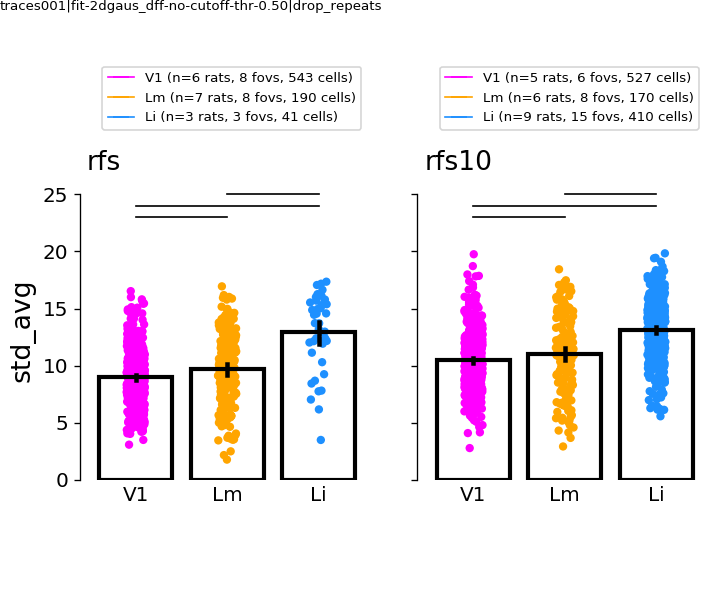

********* [rfs|mean std_avg] *********
[('V1', 'Lm')] p=0.000 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
********* [rfs10|mean std_avg] *********
[('V1', 'Lm')] p=0.004 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
std_avg_mean-all-cells_multicomp-fdr_bh__drop_repeats_reliable_bar


In [523]:
curr_metric = 'std_avg'
fov_means = False
plot_bar = True

multi_comp_test = 'fdr_bh' #'holm'
mean_metric = 'mean' # median
groupby = 'datakey' if fov_means else None
bar_str = 'bar' if plot_bar else ''
plot_str = '%s-by-%s' % (mean_metric, groupby) if fov_means else '%s-all-cells' % (mean_metric)
# ------------------------------------------------------------------------

fig, axn = pl.subplots(1, 2, figsize=(6,5), dpi=dpi, sharex=True, sharey=True)
fig.patch.set_alpha(0)
for ai, (ax, (experiment, expdf)) in enumerate(zip(axn.flat, r_df.groupby(['experiment']))):
    ax.patch.set_alpha(0)
        
    # Average RF sizes for each FOV
    grped = expdf.groupby(['visual_area', groupby]) if groupby is not None else expdf.groupby(['visual_area'])
    mean_sizes = grped.median().reset_index() if mean_metric=='median' else grped.mean().reset_index()
    # Plot means
    if plot_bar:
        sns.barplot(x="visual_area", y=curr_metric, data=expdf, 
                    ax=ax, order=visual_areas, ci=95,
                    errcolor="k", edgecolor=('k', 'k', 'k'), 
                    facecolor=(1,1,1,0), linewidth=2.5)
    else:
        sns.pointplot(x="visual_area", y=curr_metric, data=expdf, 
                        ax=ax, order=visual_areas, ci=95,
                        markers='_', join=False, capsize=0., dodge=True,
                        scale=3, color='k')
    # Plot points
    plotdf = mean_sizes if fov_means else expdf
    point_size = 10 if fov_means else 5
    sns.stripplot(x='visual_area', y=curr_metric, data=plotdf, 
                  zorder=-1, ax=ax, order=visual_areas, palette=area_colors,
                  s=point_size, color=(1,1,1,0), dodge=True, #facecolor=(1,1,1,0),
                  marker='o',linewidth=1, edgecolor='none')
    if ai>0:
        ax.set_ylabel('');
    ax.set_title(experiment, loc='left', fontsize=16)
    
    # Get counts of samples for legend
    legend_elements = aggr.get_counts_for_legend(expdf, area_colors=area_colors, markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.4), fontsize=8)
    ax.set_xlabel(''); ax.tick_params(axis='x', size=0);
    
    # Annotate w stats
    print("********* [%s|%s %s] *********" % (experiment, mean_metric, curr_metric))
    y_loc = 16 if fov_means else 23
    statresults = aggr.do_mannwhitney(plotdf, metric=curr_metric, multi_comp_test=multi_comp_test)
    aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

ylim = 0 if fov_means else 0
ax.set_ylim([ylim, ax.get_ylim()[-1]])
pl.subplots_adjust(top=0.7, bottom=0.2, left=0.12, right=0.98)
sns.despine(offset=4, trim=True, bottom=True)

label_figure(fig, data_id)
figname = '%s_RFvRF10_%s_multicomp-%s__%s_%s' % (curr_metric, plot_str, multi_comp_test, filter_str, bar_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)

Theta

### Distribution of thetas

<IPython.core.display.Javascript object>


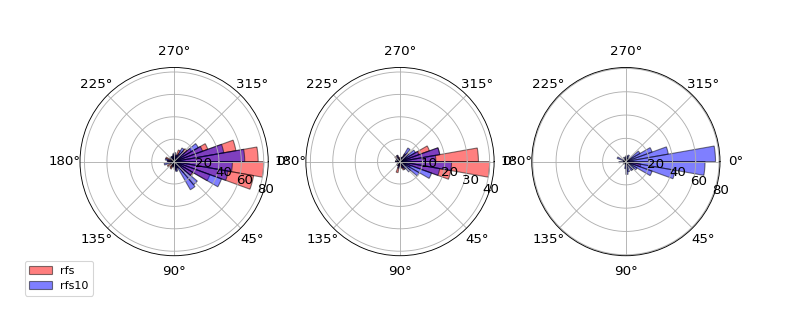

In [172]:
bin_size = 20
colors=['r', 'b']
fig, axn = pl.subplots(1,3, subplot_kw=dict(projection='polar'), figsize=(10,4))
for ax, (visual_area, vdf) in zip(axn.flat[::-1], r_df.groupby(['visual_area'])):
    # ax.scatter()
    
    for col, (experiment, g) in zip(colors, vdf.groupby(['experiment'])):
        thetas = g['theta'].values
        degrees = np.rad2deg(thetas)
        
        bin_size=10
        a , b=np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size))
        centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
        ax.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, 
               color=col, edgecolor='none', alpha=0.5, label=experiment)
        
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(-1)
ax.legend(bbox_to_anchor=(0.1, 0))

pl.subplots_adjust(left=0.1, wspace=0.2)

In [173]:
ax.get_ylim()

(0.0, 84.0)

# Anisotropy (rfs v rfs10)

#### Get x + y components of vector spanned by ellipse (major)

In [545]:
# datakey = '20190622_JC085_fov1'
# rid=25

#params=['r2', 'sigma_x', 'sigma_y', 'theta', 'x0', 'y0', 'datakey', 'cell', 'experiment', 'avg_size', 'fx', 'fy']
#df[(df['datakey']==datakey) & (df['cell']==rid)][params]

<IPython.core.display.Javascript object>


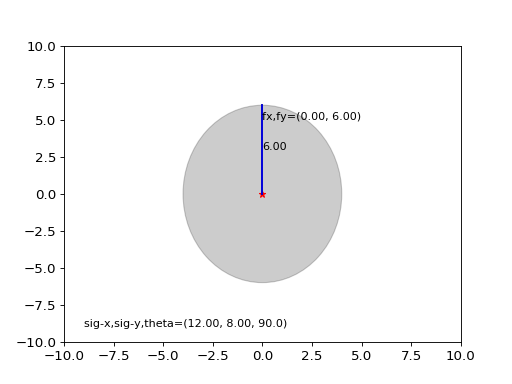

In [546]:
from matplotlib.patches import Ellipse
# 0 degrees is horizontal, where M>m
# 90 degrees, spans more along vertical axis

x0, y0 = (0, 0)
M = 12 #10
m = 8 #3
theta = 90 #np.rad2deg(4.15)
angle = np.deg2rad(theta)

fig, ax = pl.subplots() #pl.figure()
ax.plot(x0, y0, 'r*')

el = Ellipse((x0, y0), width=M, height=m, angle=theta, alpha=0.2, color='k')
ax.add_artist(el)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

F = M/2.
xe = F * np.cos(np.deg2rad(theta))
ye = F * np.sin(np.deg2rad(theta))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

fx = round(F * np.cos(np.deg2rad(theta)), 2)
fy = round(F * np.sin(np.deg2rad(theta)), 2)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, theta))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')

#ax.set_title('%s (rid %i)' % (datakey, rid))
#ax.invert_yaxis()

<IPython.core.display.Javascript object>


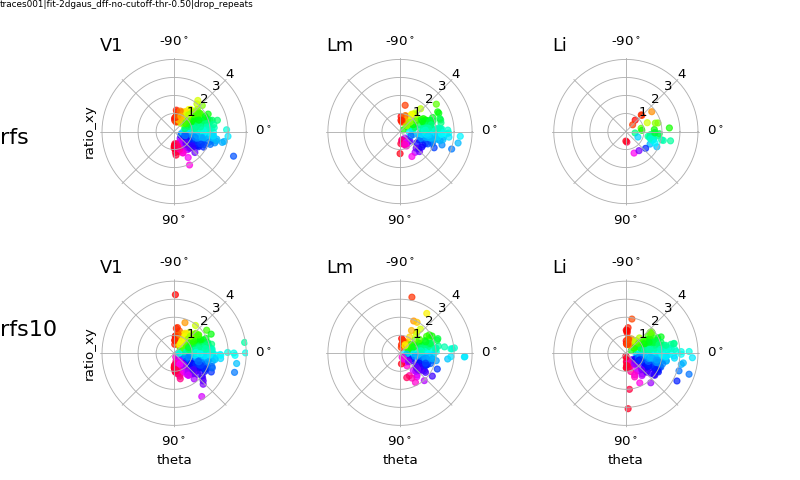

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'anisotropy_v_theta_RFvRF10__drop_repeats_reliable')


In [540]:
bin_size = 20
#colors=['r', 'b']
fig, axn = pl.subplots(2,3, subplot_kw=dict(projection='polar'), figsize=(10,6))
for ai, (visual_area, vdf) in enumerate(r_df.groupby(['visual_area'])):

    for ci, (col, (experiment, g)) in enumerate(zip(colors, vdf.groupby(['experiment']))):
        #print(experiment)
        ax = axn[ci, 2-ai]

        thetas = g['theta_c'].values #% np.pi
        ratios = g['ratio_xy'].values
        ax.scatter(thetas, ratios, s=30, c=thetas, cmap='hsv', alpha=0.7)
        
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(-1)
        ax.set_title(visual_area, fontsize=16, loc='left')
        ax.set_ylim([0, 4.1])
        ax.set_xticklabels(['0$^\circ$', '', '90$^\circ$', '', '', '', '-90$^\circ$', ''])
        if ai!=2:
            ax.set_ylabel('')
        ax.set_rlabel_position(315)
        if ci==1:
            ax.set_xlabel('theta', fontsize=12)
        else:
            ax.set_xlabel('')
        if ai==2:
            ax.set_ylabel('ratio_xy', fontsize=12)
        else:
            ax.set_ylabel('')
        # Grid lines and such
        ax.spines['polar'].set_visible(False)
        #ax.yaxis.grid(False)
        #ax.set_thetagrids([])
    
fig.text(0., 0.3, 'rfs10', fontsize=20)
fig.text(0., 0.7, 'rfs', fontsize=20)
pl.subplots_adjust(left=0.1, wspace=0.2, hspace=0.5)
label_figure(fig, data_id)

figname = 'anisotropy_v_theta_RFvRF10__%s' % filter_str
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

<IPython.core.display.Javascript object>


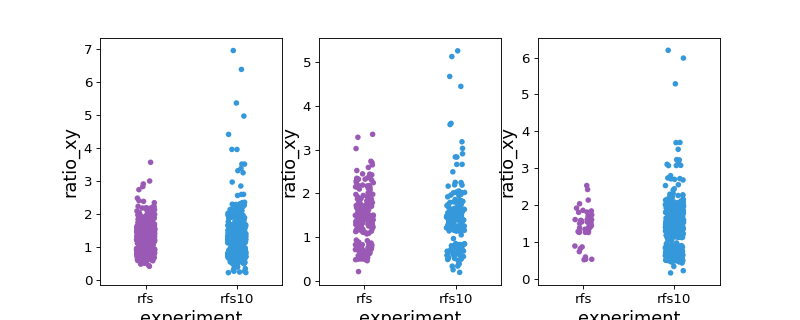

In [303]:

fig, axn = pl.subplots(1,3,figsize=(10,4))
for ax, (visual_area, vdf) in zip(axn.flat[::-1], r_df.groupby(['visual_area'])):
    
    sns.stripplot(x='experiment', y='ratio_xy', data=vdf, ax=ax)
    

# General Stats

In [414]:
# scale_sigma = False
# reliable_only = True

# #### Get non-repeated FOV datasets
# r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
#                                                   traceid=traceid, fit_desc=fit_desc,
#                                                   reliable_only=reliable_only,
#                                                   #scale_sigma=scale_sigma, 
#                                                   fov_type=fov_type, state=state, stimulus='rfs')

# #### Make sure only 1 experiment type per dset
# rdf_list=[]
# for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
#     expname = 'rfs' if visual_area=='V1' else 'rfs10'
#     altname = 'rfs' if expname=='rfs10' else 'rfs10'
#     if expname not in g['experiment'].values:
#         vdf = g[g['experiment']==altname]
#     else:
#         vdf = g[g['experiment']==expname]
#     rdf_list.append(vdf)
# df = pd.concat(rdf_list)

# #### Filter for good fits only
# df = df[df['r2']>fit_thr]
# df.groupby(['visual_area']).count()
    
# #### Split fx, fy for theta comp
# fx = abs(df[['std_x', 'std_y']].max(axis=1) * np.cos(df['theta']))
# fy = abs(df[['std_x', 'std_y']].max(axis=1) * np.sin(df['theta']))

# df['fx'] = fx
# df['fy'] = fy

# df['ratio_xy'] = df['std_x']/df['std_y']

# degrees = np.rad2deg(df['theta'].values)
# thetas = np.deg2rad([(t % 180) - 180 if ((90<t<180) or (270<t<360)) else (t % 180) for t in degrees])
# df['theta_c'] = thetas

droppin repeats
[filter_by=drop_repeats] Excluding 24 total repeats
Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4


In [229]:
# df.groupby(['visual_area']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  datakey  \
visual_area                                                                  
Li           429     429     429    429  429  429       429   429      429   
Lm           346     346     346    346  346  346       346   346      346   
V1           630     630     630    630  630  630       630   630      630   

             experiment    ...     session  std_x  std_y  fwhm_avg  std_avg  \
visual_area                ...                                                
Li                  429    ...         429    429    429       429      429   
Lm                  346    ...         346    346    346       346      346   
V1                  630    ...         630    630    630       630      630   

             area  datakey_ix   fx   fy  ratio_xy  
visual_area                                        
Li            429         429  429  429       429  
Lm            346         346  346  346       346  
V1            630         630  630  630       630  

[3 rows x 21 columns]

## Anisotropy v Orientation

<IPython.core.display.Javascript object>


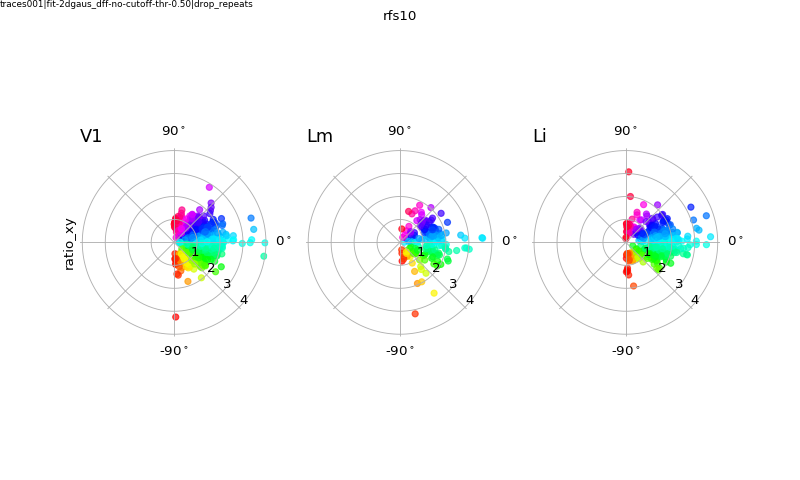

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'anisotropy_v_theta_rfs10__drop_repeats_reliable')


In [548]:
# ---------------------------------------------------
rfname = 'rfs10'
expdf = r_df[r_df['experiment']==rfname].copy()
# ---------------------------------------------------

fig, axn = pl.subplots(1,3, subplot_kw=dict(projection='polar'), figsize=(10,6))
for ai, (visual_area, g) in enumerate(expdf.groupby(['visual_area'])):
    ax = axn[2-ai]
    thetas = g['theta_c'].values #% np.pi
    ratios = g['ratio_xy'].values
    ax.scatter(thetas, ratios, s=30, c=thetas, cmap='hsv', alpha=0.7)

    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_title(visual_area, fontsize=16, loc='left')
    ax.set_ylim([0, 4.1])
    ax.set_xticklabels(['0$^\circ$', '', '90$^\circ$', '', '', '', '-90$^\circ$', ''])
    if ai!=2:
        ax.set_ylabel('')
    ax.set_rlabel_position(315)
    ax.set_xlabel('')
    if ai==2:
        ax.set_ylabel('ratio_xy', fontsize=12)
    else:
        ax.set_ylabel('')
    # Grid lines and such
    ax.spines['polar'].set_visible(False)
    #ax.yaxis.grid(False)
    #ax.set_thetagrids([])
pl.suptitle(rfname)
pl.subplots_adjust(left=0.1, wspace=0.2, hspace=0.5)
label_figure(fig, data_id)

figname = 'anisotropy_v_theta_%s__%s' % (rfname, filter_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

## Plot x- and y-components of fit RFs

<IPython.core.display.Javascript object>


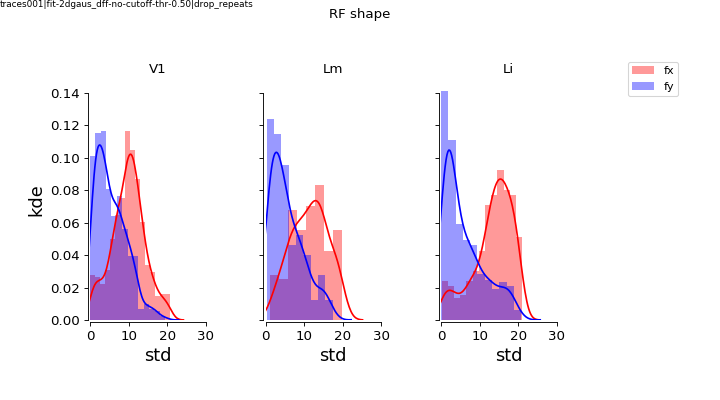

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'split_fxy_rfs10__drop_repeats_reliable')


In [552]:
split_components = True
curr_metric = 'std'

x_color = 'r'
y_color = 'b'

# ----------------------------------------------
rfname = 'rfs10'
expdf = r_df[r_df['experiment']==rfname].copy()
# ----------------------------------------------

xlim = 25 if curr_metric=='std' else 60.
if split_components:
    xlim=35
else:
    xlim = 60 if scale_sigma else 30
sz_metric = 'f' if split_components else '%s_' % curr_metric

fig, axes = pl.subplots(1,3, figsize=(9,5), sharey=True, sharex=True)
for ax, visual_area in zip(axes.flat, visual_areas):
    g = expdf[expdf['visual_area']==visual_area].copy()
    
    sns.distplot(g['%sx' % sz_metric], color=x_color, ax=ax, label='%sx' % sz_metric)
    sns.distplot(g['%sy' % sz_metric], color=y_color, ax=ax, label='%sy' % sz_metric)
    ax.set_title(visual_area)
    
    ax.set_xlim([0, xlim])
    ax.set_xlabel(curr_metric)
sns.despine(trim=True, offset=2)
    
pl.subplots_adjust(wspace=0.3, right=0.8, top=0.8, bottom=0.2)
axes[0].set_ylabel('kde')
axes[2].legend(bbox_to_anchor=(1.8, 1.1))

label_figure(fig, data_id)
fig.suptitle('RF shape')

figname = 'split_%sxy_%s__%s' % (sz_metric, rfname, filter_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

# Look at all params

In [554]:
fieldnames = ['x0', 'y0', 'theta_c', '%s_x' % curr_metric, '%s_y' % curr_metric, 
              '%s_avg' % curr_metric, 'fx', 'fy', 'visual_area']
print(fieldnames)

['x0', 'y0', 'theta_c', 'std_x', 'std_y', 'std_avg', 'fx', 'fy', 'visual_area']


<IPython.core.display.Javascript object>


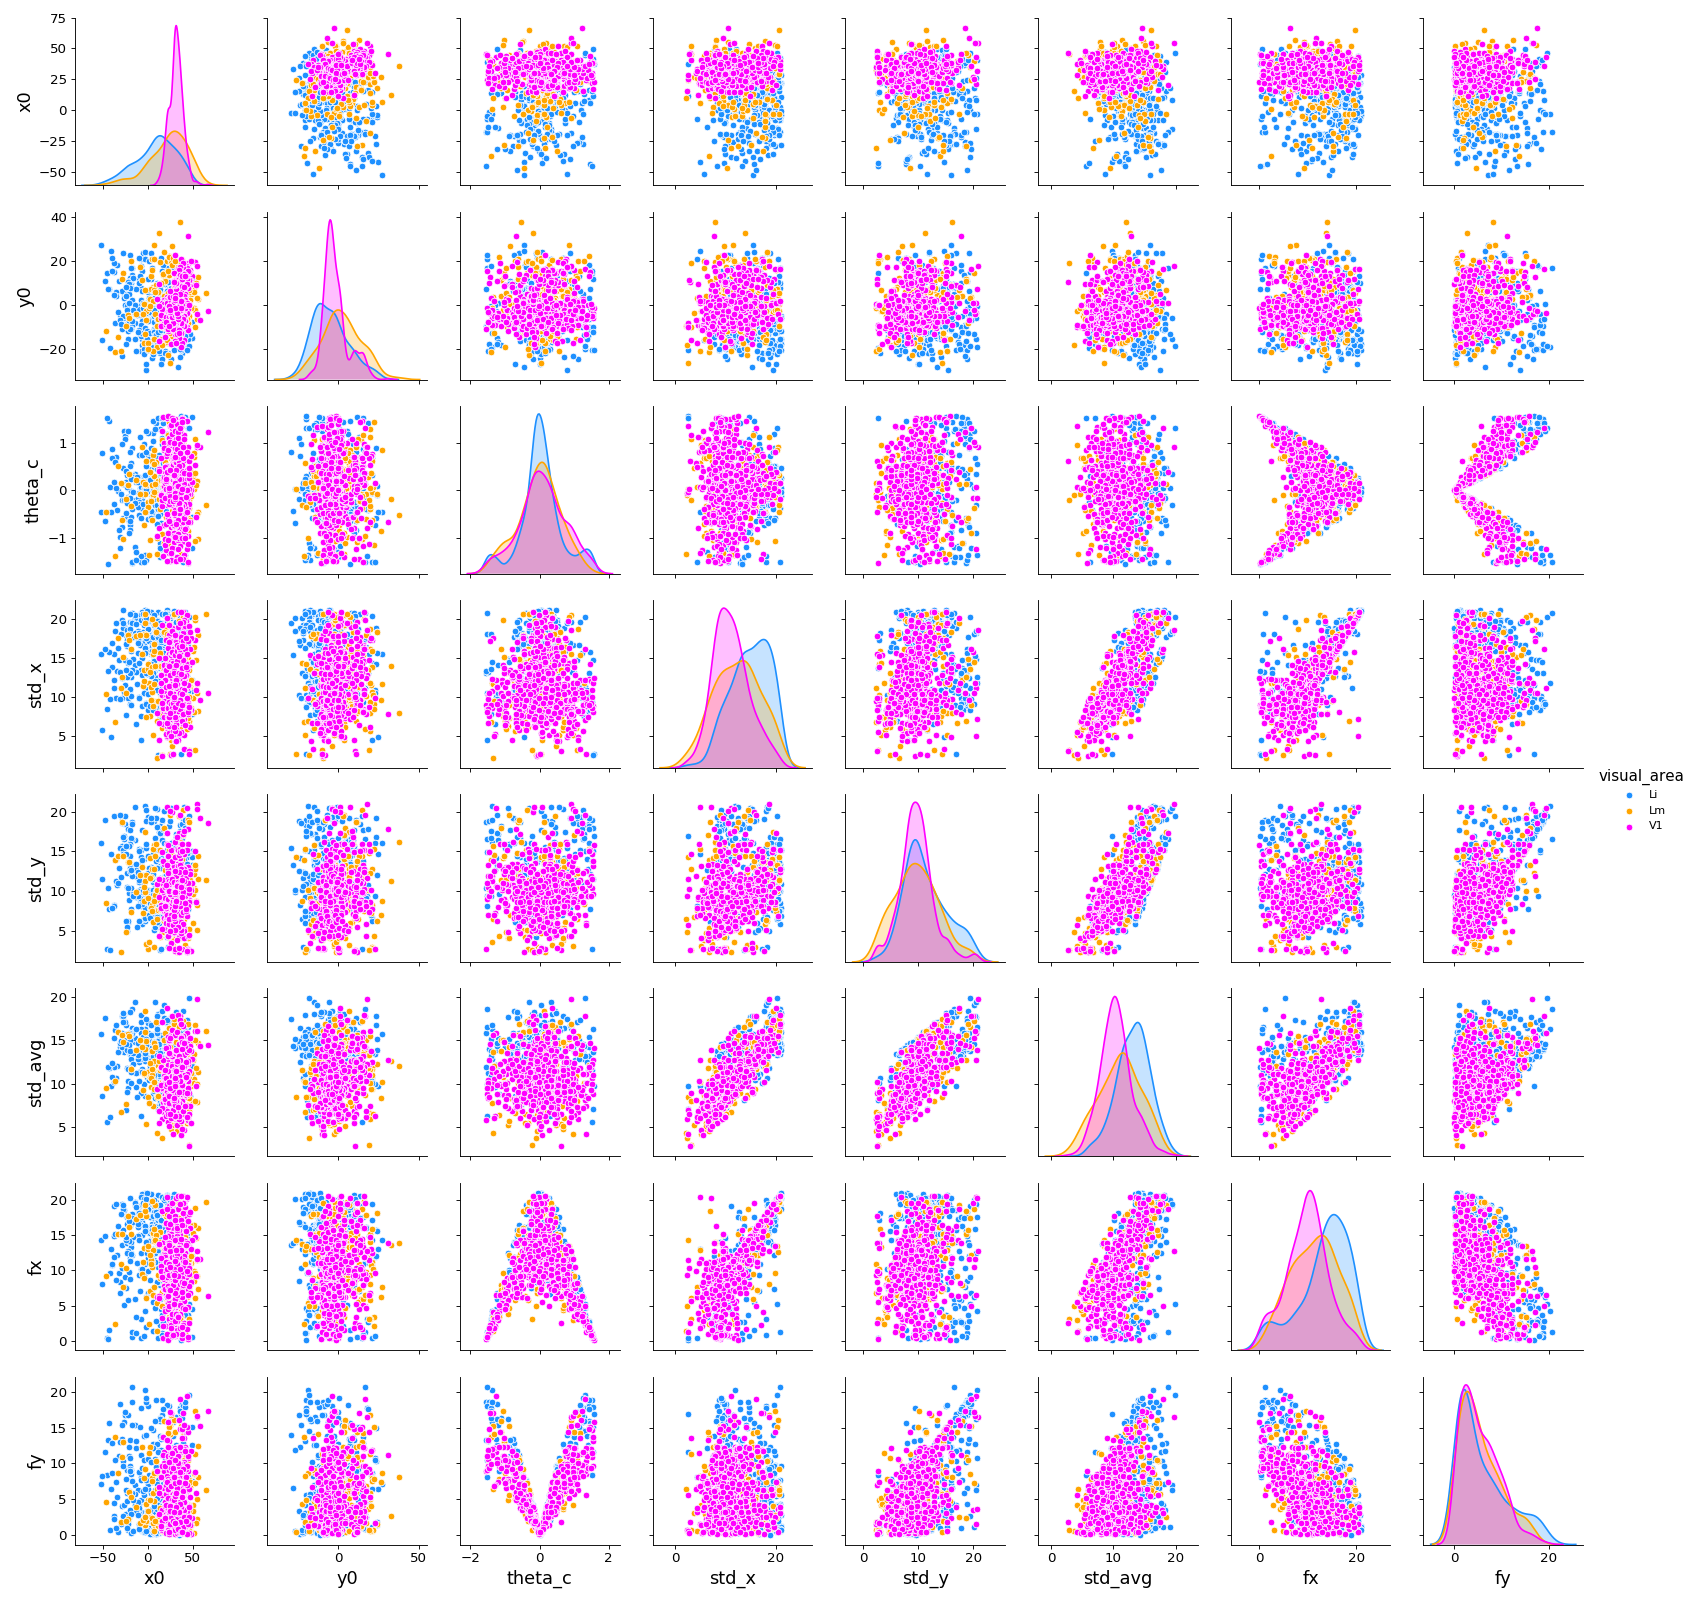

In [555]:
# theta = 90 is vertically-long, 0 = horizontal

# ----------------------------------------------
rfname = 'rfs10'
expdf = r_df[r_df['experiment']==rfname].copy()
# ----------------------------------------------

sns.pairplot(expdf[fieldnames], hue='visual_area', palette=area_colors)
pl.savefig(os.path.join(genstats_dir, 'all_params_pairplot_%s__%s.png' % (rfname, filter_by)))


## Check out thetas

<IPython.core.display.Javascript object>


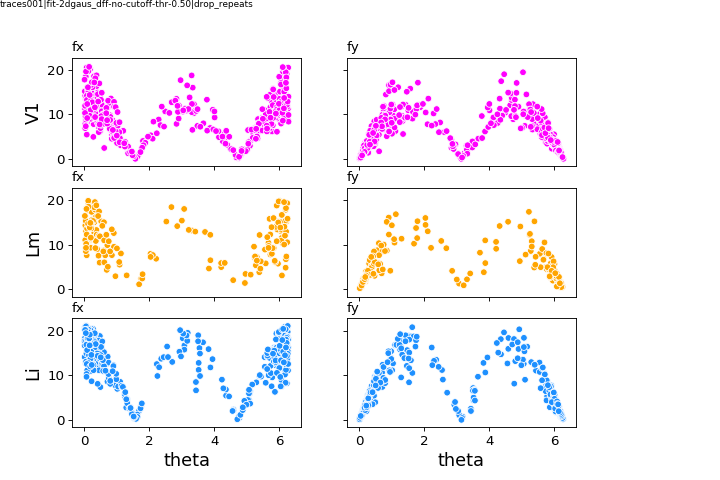

In [556]:
fig, axn = pl.subplots(3,2,figsize=(9,6), sharex=True, sharey=True)
for ri, visual_area in enumerate(visual_areas):
    g = expdf[expdf['visual_area']==visual_area]
    ax = axn[ri, 0]
    sns.scatterplot(x='theta', y='fx', hue='visual_area', palette=area_colors, data=g, ax=ax, legend=0)
    ax.set_ylabel(visual_area)
    ax.set_title('fx', loc='left')
    
    ax = axn[ri, 1]
    sns.scatterplot(x='theta', y='fy', hue='visual_area', palette=area_colors, data=g, ax=ax, legend=0)
    ax.set_title('fy', loc='left')

pl.subplots_adjust(wspace=0.2, right=0.8, left=0.1)
label_figure(fig, data_id)

pl.savefig(os.path.join(genstats_dir, 'fx_fy_by_theta_%s__%s.svg' % (rfname, filter_by)))

# Visualize general stats

### 1. Average RF size

<IPython.core.display.Javascript object>


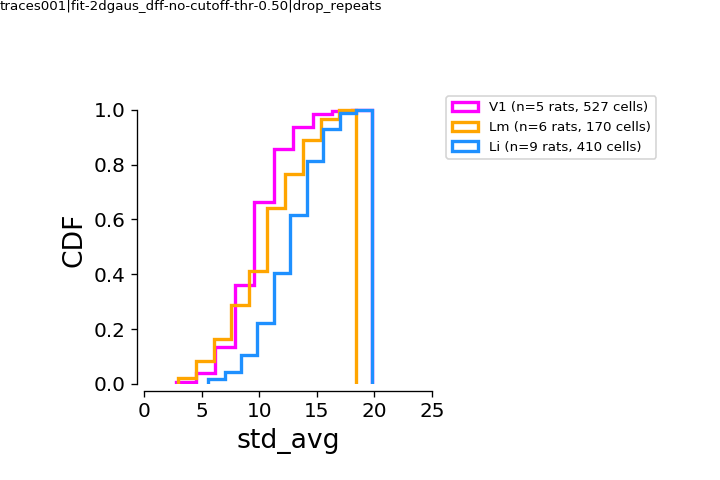

std_avg_rfs10__drop_repeats_reliable_cdf


In [557]:
curr_metric = 'std_avg'
cdf = True
plot_type = 'cdf' if cdf else 'hist'
max_size = 50 if scale_sigma else 30

# -------------------------------------------------
rfname = 'rfs10'
expdf = r_df[r_df['experiment']==rfname].copy()
# -------------------------------------------------

fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax = rfutils.compare_rf_size(expdf, metric=curr_metric, cdf=cdf, ax=ax, alpha=1)
ax.set_xlim([0, 25])
sns.despine(ax=ax, trim=True, offset=4)

pl.subplots_adjust(right=0.6, top=0.8, bottom=0.2, left=0.2)

label_figure(fig, data_id)
figname = '%s_%s__%s_%s' % (curr_metric, rfname, filter_str, plot_type)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)

## 2. Bar plot for fov averages

<IPython.core.display.Javascript object>


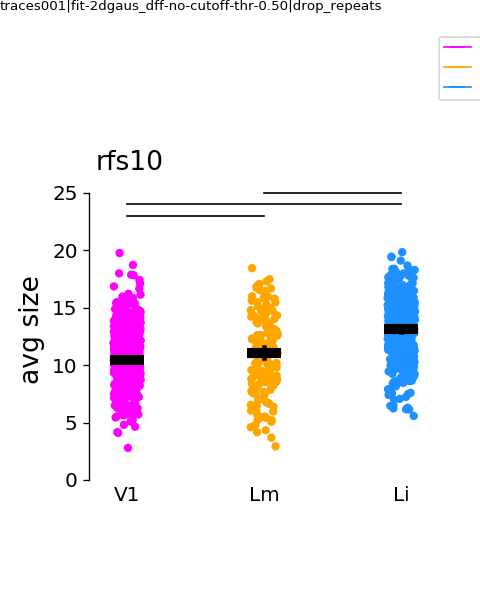

********* [rfs10|mean std_avg] *********
[('V1', 'Lm')] p=0.004 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
std_avg_rfs10_mean-all-cells_multicomp-fdr_bh__drop_repeats_reliable_


In [561]:
curr_metric = 'std_avg'
fov_means = False
plot_bar = False

multi_comp_test = 'fdr_bh' #'holm'
mean_metric = 'mean' # median
groupby = 'datakey' if fov_means else None
bar_str = 'bar' if plot_bar else ''
plot_str = '%s-by-%s' % (mean_metric, groupby) if fov_means else '%s-all-cells' % (mean_metric)


# ------------------------------------------------------------------------
rfname = 'rfs10'
expdf = r_df[r_df['experiment']==rfname].copy()
# ------------------------------------------------------------------------

fig, ax = pl.subplots(figsize=(4,5), dpi=dpi, sharex=True, sharey=True)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

# Average RF sizes for each FOV
grped = expdf.groupby(['visual_area', groupby]) if groupby is not None else expdf.groupby(['visual_area'])
mean_sizes = grped.median().reset_index() if mean_metric=='median' else grped.mean().reset_index()

# Plot means
if plot_bar:
    sns.barplot(x="visual_area", y=curr_metric, data=expdf, 
                ax=ax, order=visual_areas, ci=95,
                errcolor="k", edgecolor=('k', 'k', 'k'), 
                facecolor=(1,1,1,0), linewidth=2.5)
else:
    sns.pointplot(x="visual_area", y=curr_metric, data=expdf, 
                    ax=ax, order=visual_areas, ci=95,
                    markers='_', join=False, capsize=0., dodge=True,
                    scale=3, color='k')
# Plot points
plotdf = mean_sizes if fov_means else expdf
point_size = 10 if fov_means else 5
sns.stripplot(x='visual_area', y=curr_metric, data=plotdf, 
              zorder=-1, ax=ax, order=visual_areas, palette=area_colors,
              s=point_size, color=(1,1,1,0), dodge=True, #facecolor=(1,1,1,0),
              marker='o',linewidth=1, edgecolor='none')
if ai>0:
    ax.set_ylabel('');
ax.set_title(experiment, loc='left', fontsize=16)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(expdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.5), fontsize=8)
ax.set_xlabel(''); ax.tick_params(axis='x', size=0);

# Annotate w stats
print("********* [%s|%s %s] *********" % (experiment, mean_metric, curr_metric))
y_loc = 16 if fov_means else 23
statresults = aggr.do_mannwhitney(expdf, metric=curr_metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

ylim = 0 if fov_means else 0
ax.set_ylim([ylim, ax.get_ylim()[-1]])
pl.subplots_adjust(top=0.7, bottom=0.2, left=0.2, right=0.9)
sns.despine(offset=4, trim=True, bottom=True)

ax.set_ylabel('avg size');
ax.set_title(experiment, loc='left', fontsize=16)



label_figure(fig, data_id)
figname = '%s_%s_%s_multicomp-%s__%s_%s' % (curr_metric, rfname, plot_str, multi_comp_test, filter_str, bar_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)

## Distn of all rf sizes

<IPython.core.display.Javascript object>


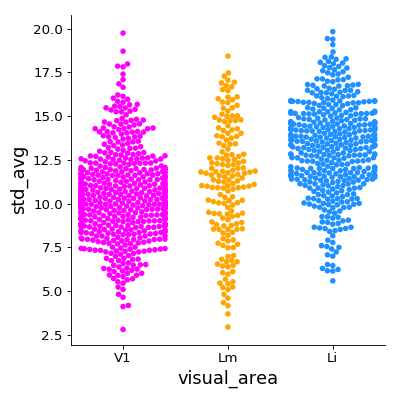

distns_std_avg_rfs10__drop_repeats


In [563]:
curr_metric = 'std_avg'
plot_kind = 'swarm'

fg = sns.catplot(x="visual_area", y=curr_metric, data=expdf,# col='experiment',
           palette=area_colors, order=visual_areas, kind=plot_kind, dodge=True, 
                 edgecolor='w', linewidth=0, alpha=1)

figname = 'distns_%s_%s__%s' % (curr_metric, rfname, filter_by)
fg.fig.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)

In [565]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

## Look at N cells fit 

<IPython.core.display.Javascript object>


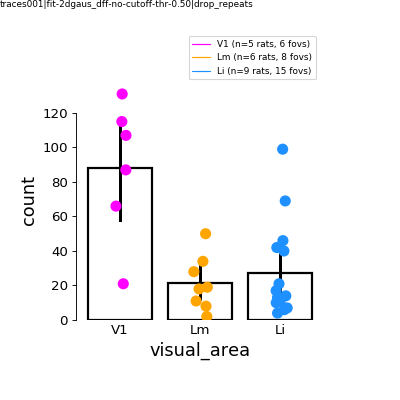

********* n_cells **********
[('V1', 'Lm')] p=0.006 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.006 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.487 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'n_cells_rfs10_avg-fov_multicomp-fdr_bh__drop_repeats')


In [569]:
curr_metric = 'n_cells'

# ------------------------------------------------------------------------
rfname = 'rfs10'
expdf = r_df[r_df['experiment']==rfname].copy()
# ------------------------------------------------------------------------

countdf = expdf.groupby([ 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf.rename(columns={'cell': 'n_cells'}, inplace=True)

fg = sns.catplot(x="visual_area", y=curr_metric, data=countdf, #hue="experiment", 
               kind = 'bar',
                errcolor="k", edgecolor=('k', 'k', 'k'), order=visual_areas,
                facecolor=(1,1,1,0), linewidth=2, zorder=0, legend=0) #, ax=ax)
sns.stripplot(x='visual_area', y=curr_metric, data=countdf, #hue='experiment',
             order=visual_areas, ax=fg.ax, palette=area_colors, dodge=True,
             size=10)
fg.ax.tick_params(axis='x', size=0)
fg.ax.set_ylabel('count')

pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True, ax=fg.ax)
fg.ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(countdf, area_colors=area_colors, markersize=10, marker='_')
fg.ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


print("********* %s **********" % (curr_metric))
statresults = aggr.do_mannwhitney(countdf, metric=curr_metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, lw=1, color='k', 
                         visual_areas=['V1', 'Lm', 'Li'])
print("****************************")

    
#fg.ax.set_title('N cells with good fits(within 95% CI)', loc='left')
label_figure(fg.fig, data_id)

figname = '%s_%s_avg-fov_multicomp-%s__%s' % (curr_metric, rfname, multi_comp_test, filter_by)
fg.fig.savefig(os.path.join(genstats_dir, '%s.svg' % figname))

print(genstats_dir, figname)


## All fit params

In [573]:
curr_metric = 'std'
params = ['x0', 'y0', 'theta_c', '%s_x' % curr_metric, '%s_y' % curr_metric, 
              '%s_avg' % curr_metric, 'fx', 'fy', 'visual_area']
print(params)

['x0', 'y0', 'theta_c', 'std_x', 'std_y', 'std_avg', 'fx', 'fy', 'visual_area']


<IPython.core.display.Javascript object>


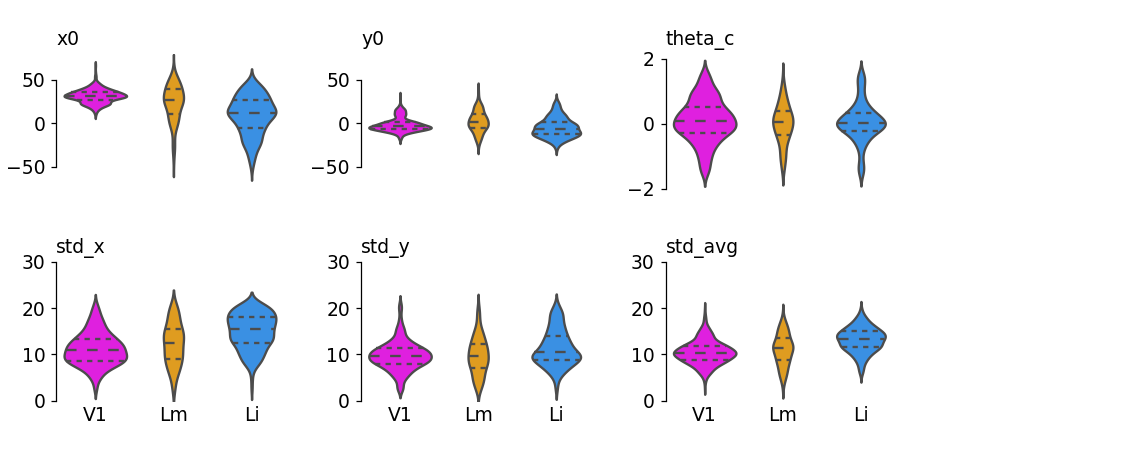

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'all-metrics_rfs10__drop_repeats_reliable_violin')


In [574]:
plot_type = 'violin'

# ------------------------------------------------------------------------
rfname = 'rfs10'
expdf = r_df[r_df['experiment']==rfname].copy()
# ------------------------------------------------------------------------

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)
for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    if plot_type=='violin':
        sns.violinplot(x='visual_area', y=param, data=expdf, ax=ax,
                      palette=area_colors, order=visual_areas,
                       scale='count', inner='quartile')
    else:
        sns.swarmplot(x='visual_area', y=param, data=expdf, ax=ax,
                      palette=area_colors, dodge=True, order=visual_areas)
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)

    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
    if param=='theta':
        ax.set_ylim([-np.pi, 3*np.pi])
    elif param in ['x0','y0']:
        ax.set_ylim([-80, 80])
    elif 'fwhm' in param:
        ax.set_ylim([0, 60])
    elif 'std' in param:
        ax.set_ylim([0, 30])
    sns.despine(trim=True, ax=ax, bottom=True)
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)

# Save
figname = 'all-metrics_%s__%s_%s' % (rfname, filter_str, plot_type)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))

print(genstats_dir, figname)    

# Compare cortical position vs. VF position

In [47]:
def get_fov_coordinates(animalid, session, fov, rffits):

    S = util.Session(animalid, session, fov)
    experiment_list = S.get_experiment_list()
    if 'rfs10' in experiment_list:
        S.get_experiment_data(experiment='rfs10')
        rf_exp_name = 'rfs10'
    else:
        S.get_experiment_data(experiment='rfs')
        rf_exp_name= 'rfs'
    
    masks, zimg = S.load_masks()
    roi_contours = coords.contours_from_masks(masks)
    # Convert to brain coords
    fov_pos_x, rf_xpos, xlim, fov_pos_y, rf_ypos, ylim = coords.get_roi_position_um(rffits, roi_contours, 
                                                                         rf_exp_name=rf_exp_name,
                                                                         convert_um=True)
    
    posdf = pd.DataFrame({'xpos_fov': fov_pos_y,
                          'xpos_rf': rf_xpos,
                          'ypos_fov': fov_pos_x,
                          'ypos_rf': rf_ypos,
                         'visual_area': [visual_area for _ in range(len(fov_pos_x))],
                         'animalid': [animalid for _ in range(len(fov_pos_x))],
                         'session': [session for _ in range(len(fov_pos_x))],
                         'fov': [fov for _ in range(len(fov_pos_x))]})
    return posdf


#### Create output subdir

In [48]:
scatter_dir = os.path.join(outdir, 'scatter', '%s_2' %filter_by)
if not os.path.exists(scatter_dir):
    os.makedirs(scatter_dir)
print(scatter_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats_2


#### Load converted RF positions

In [575]:
from pipeline.python.rois.utils import load_roi_coords

In [581]:
reliable_str = 'reliable' if reliable_only else 'allfit'
df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s_%s.pkl' % (filter_by, reliable_str, rfname))
print(df_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_rfs10.pkl


In [582]:
# with open(df_fpath, 'wb') as f:
#     pkl.dump(df, f, protocol=pkl.HIGHEST_PROTOCOL)
# print(df_fpath)

In [583]:
get_positions = True

if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df = pkl.load(f)
    except Exception as e:
        get_positions = True
print(get_positions)

True


In [587]:

if get_positions:
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        expdf[p] = ''
    p_list=[]
    for (animalid, session, fovnum), g in expdf.groupby(['animalid', 'session', 'fovnum']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            expdf[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)
    

Calculating RF coord conversions...
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords


In [588]:
expdf.groupby(['visual_area']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  datakey  \
visual_area                                                                  
Li           410     410     410    410  410  410       410   410      410   
Lm           170     170     170    170  170  170       170   170      170   
V1           527     527     527    527  527  527       527   527      527   

             experiment   ...     fx   fy  ratio_xy  theta_c  fov_xpos  \
visual_area               ...                                            
Li                  410   ...    410  410       410      410       410   
Lm                  170   ...    170  170       170      170       170   
V1                  527   ...    527  527       527      527       527   

             fov_xpos_pix  fov_ypos  fov_ypos_pix  ml_pos  ap_pos  
visual_area                                                        
Li                    410       410           410     410     410  
Lm                    170       170           170     170     170  
V1                    527       527           527     527     527  

[3 rows x 28 columns]

In [72]:
df.groupby(['visual_area']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  datakey  \
visual_area                                                                  
Li           429     429     429    429  429  429       429   429      429   
Lm           346     346     346    346  346  346       346   346      346   
V1           630     630     630    630  630  630       630   630      630   

             experiment   ...    area  datakey_ix   fx   fy  fov_xpos  \
visual_area               ...                                           
Li                  429   ...     429         429  429  429       429   
Lm                  346   ...     346         346  346  346       346   
V1                  630   ...     630         630  630  630       630   

             fov_xpos_pix  fov_ypos  fov_ypos_pix  ml_pos  ap_pos  
visual_area                                                        
Li                    429       429           429     429     429  
Lm                    346       346           346     346     346  
V1                    630       630           630     630     630  

[3 rows x 26 columns]

## Pairwise distances

In [589]:
from scipy.spatial.distance import pdist
#dists = skmetrics.pairwise.euclidean_distances(tmpd, Y=None) #, metric='euclidean')
import itertools

from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

#### Look at PW distances of by dataset

In [590]:
min_cells = 5

pair_names = [('fov_x', 'ml_pos'), ('fov_y', 'ap_pos'), ('rf_x', 'x0'), ('rf_y', 'y0')]

d_list = []
# Get all pairwise distances between rf positions:
for (visual_area, animalid, session, fovnum), g in expdf.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    if g.shape[0] <= min_cells:
        continue
        
    diffs={}
    for (d1, d2) in pair_names:
        xx = g[d2].values
        diffs[d1] = np.abs([t1-t2 for i, t1 in enumerate(xx) for t2 in xx[i + 1:]])
        npairs = len(list(itertools.combinations(range(len(xx)), 2)))
        assert len(diffs[d1]) == npairs, "bad combos"

    d_df = pd.DataFrame(diffs)
    d_df['animalid'] = [animalid for _ in np.arange(0, npairs)]
    d_df['session'] = [session for _ in np.arange(0, npairs)]
    d_df['fovnum'] = [fovnum for _ in np.arange(0, npairs)]
    d_df['visual_area'] = [visual_area for _ in np.arange(0, npairs)]
    d_df['datakey'] = ['%s_%s_fov%i' % (animalid, session, fovnum) for _ in np.arange(0, npairs)]

    d_list.append(d_df)
    
diff_df = pd.concat(d_list, axis=0).reset_index(drop=True)

In [591]:
print(diff_df.shape)
diff_df.head()

(39987, 9)


fov_x       fov_y       rf_x       rf_y animalid   session  fovnum  \
0   74.245010  235.059100  42.313861  10.856852    JC089  20190522       1   
1  188.468102  262.713112  53.584878  13.892473    JC089  20190522       1   
2  296.980039  182.055577  41.613033  13.656004    JC089  20190522       1   
3  390.262231  133.661057  32.783722  22.889158    JC089  20190522       1   
4  371.225049  271.931115  37.542110  13.579386    JC089  20190522       1   

  visual_area              datakey  
0          Li  JC089_20190522_fov1  
1          Li  JC089_20190522_fov1  
2          Li  JC089_20190522_fov1  
3          Li  JC089_20190522_fov1  
4          Li  JC089_20190522_fov1

In [592]:
diff_df[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                14
Lm                 7
V1                 6

## Split PW dist calculation by azimuth/elevation

<IPython.core.display.Javascript object>


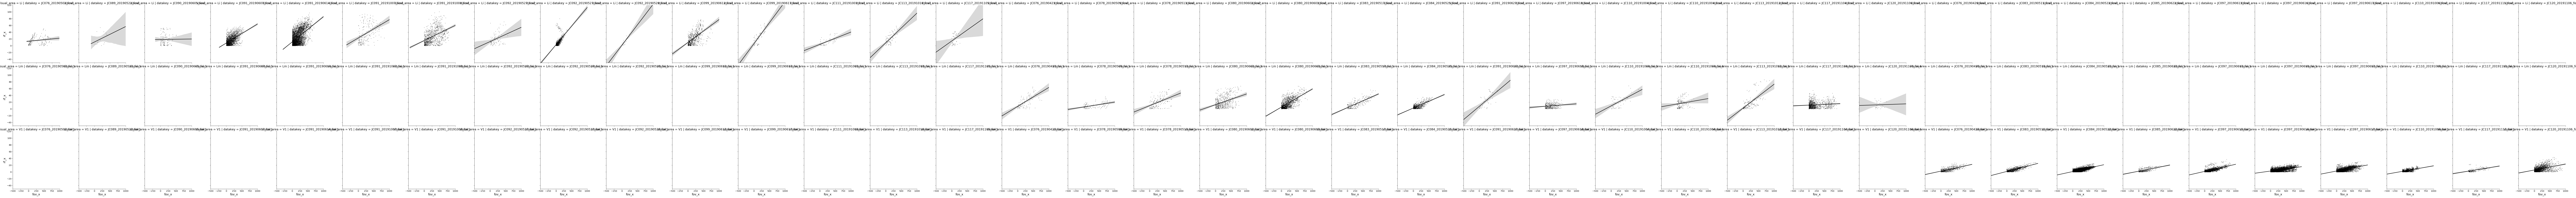

In [79]:
# # Plot regression w/ CI
# xvar = 'fov'
# yvar = 'rf'


# g = sns.lmplot('%s_x' % xvar, '%s_x' % yvar, data=diff_df, 
#                row='visual_area', col='datakey', #col_wrap=6,
#           scatter_kws={'s': 1,
#                       'marker':'+',
#                       'color': 'k'},
#           line_kws={'color': 'k'})
# g.fig.patch.set_alpha(1)
# g.set(xlim=(-500, 1000), ylim=(-50, 120))


<IPython.core.display.Javascript object>


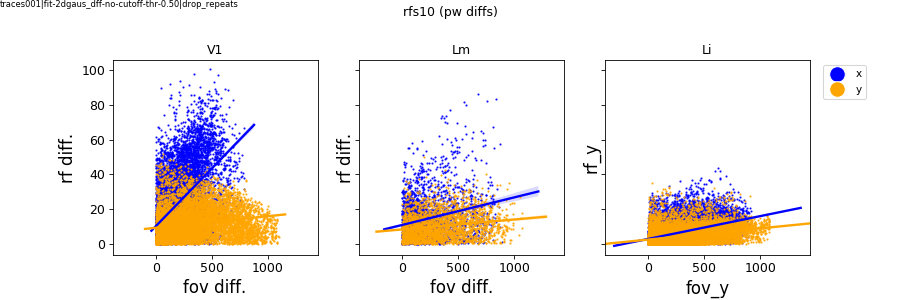

In [595]:
fig, axn = pl.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
for ci, (visual_area, g) in enumerate(diff_df.groupby(['visual_area'])):
    for (axi, col) in zip(['x', 'y'], ['blue', 'orange']):
        
        sns.regplot('fov_%s' % axi, 'rf_%s' % axi, data=g, ax=axn[ci],
                   scatter=True, color=col, truncate=False,
                   marker='.', scatter_kws={'s': 5})
    axn[2-ci].set_title(visual_area)
    axn[2-ci].set_xlabel('fov diff.')
    axn[2-ci].set_ylabel('rf diff.')
    
# legend
leg_elements = [Line2D([0], [0], marker='o', color='w', label='x',
                          markerfacecolor='blue', markersize=15),
               Line2D([0], [0], marker='o', color='w', label='y',
                          markerfacecolor='orange', markersize=15)]
axn[-1].legend(handles=leg_elements, bbox_to_anchor=(1.3, 1))
pl.suptitle('%s (pw diffs)' % rfname)

label_figure(fig, data_id)
pl.subplots_adjust(top=0.8, bottom=0.15)
figname = '_%s_pwdiffs_split_xy_by_visual_area' % rfname
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))

## Linear fit

In [597]:
# Plot regression w/ CI
xvar = 'fov'
yvar = 'rf'
d_list=[]
i=0
for (visual_area, animalid, session, fovnum, datakey), currdf in diff_df.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
    for axi in ['x', 'y']:
        
        xv = currdf['fov_%s' % axi].values
        yv = currdf['rf_%s' % axi].values
        
        fitv, regr = evalrf.fit_linear_regr(xv, yv, return_regr=True)
        # ax.plot(xv, fitv, curr_color)
        rmse = np.sqrt(skmetrics.mean_squared_error(yv, fitv))
        r2 = skmetrics.r2_score(yv, fitv)
        pearson_p, pearson_r = spstats.pearsonr(xv, yv)
            
        
        tmpdf = pd.DataFrame({'slope': float(regr.coef_),
                              'R2': r2,
                              'RMSE': rmse,
                              'axis': axi,
                              'pearson_p': pearson_p,
                              'pearson_r': pearson_r,
                              'n_cells': df[df['datakey']==datakey].shape[0], #len(yv),
                              'animalid': animalid, 'session': session, 'fovnum': fovnum,
                              'visual_area': visual_area,
                              'datakey': '%s_%s_fov%i' % (session, animalid, fovnum)}, index=[i])
        
        d_list.append(tmpdf)
        i+=1
pwslopes = pd.concat(d_list, axis=0).reset_index(drop=True)


<IPython.core.display.Javascript object>


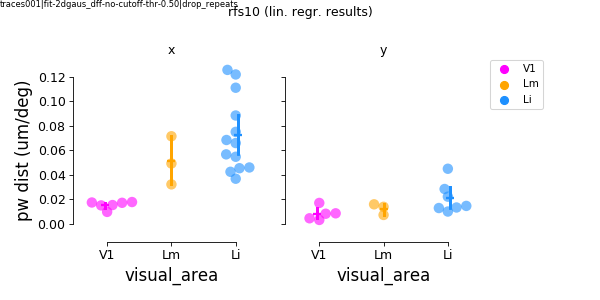

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', '_rfs10_regr_pw_dists_rfpos_vs_fovpos_split_xy_R2-0.04__drop_repeats_reliable')


In [607]:
metric = 'slope'
fig, axn = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

R2_thr = 0.04
thr_str = 'R2-%.2f' % R2_thr
curr_df = pwslopes[pwslopes['R2'] > R2_thr]

for ax, axi in zip(axn.flat, ['x', 'y']):
    
    axdf = curr_df[(curr_df['axis']==axi)]
    
    g = sns.swarmplot(x='visual_area', y=metric, hue='visual_area', ax=ax,
                      palette=area_colors, data=axdf.sort_values(by='visual_area', ascending=False),
                     marker='o', facecolor='none', s=10,  alpha=0.6)

    for ai, visual_area in enumerate(visual_areas):
        mval =  axdf[axdf['visual_area']==visual_area][metric].mean()

        sns.pointplot(x='visual_area', y=metric, hue='visual_area', legend=False,
                     data=axdf.sort_values(by='visual_area', ascending=False),
                     ci=95, capsize=0., alpha=0.7,
                     palette=area_colors, dodge=True, markers='_', join=False, ax=ax)
    ax.set_title(axi)
    ax.set_ylabel('')

    if axi == 'x':
        ax.legend_.remove()
    else:
        # Get the handles and labels. For this example it'll be 2 tuples
        # of length 4 each.
        handles, labels = ax.get_legend_handles_labels()

        # When creating the legend, only use the first two elements
        # to effectively remove the last two.
        l = pl.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

axn[0].set_ylabel('pw dist (um/deg)')
sns.despine(trim=True, offset=2)
pl.subplots_adjust(wspace=0.1, right=0.8, top=0.8, bottom=0.2)
fig.suptitle('%s (lin. regr. results)' % rfname)

label_figure(fig, data_id)

figname = '_%s_regr_pw_dists_rfpos_vs_fovpos_split_xy_%s__%s' % (rfname, thr_str, filter_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

<IPython.core.display.Javascript object>


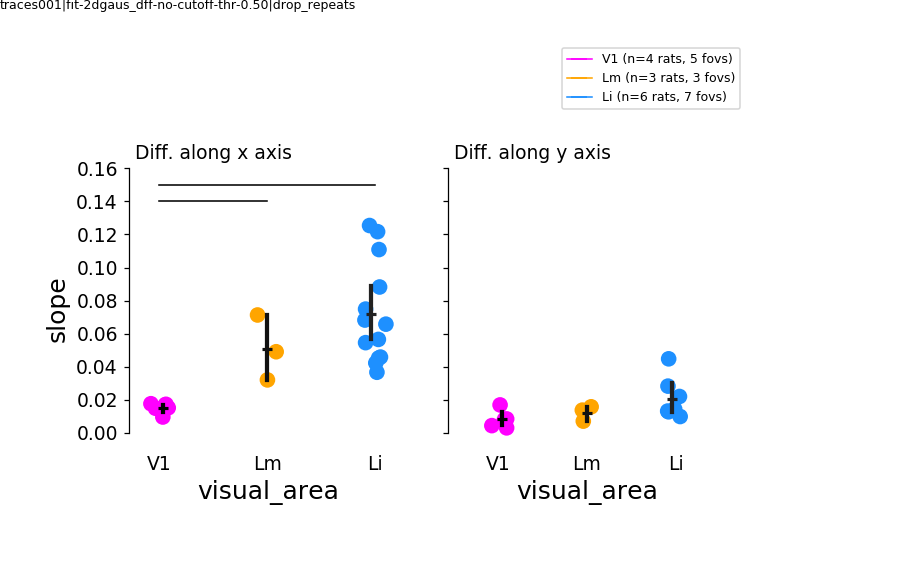

********* slope **********
[('V1', 'Lm')] p=0.028 (holm), reject H0=True
[('V1', 'Li')] p=0.001 (holm), reject H0=True
[('Lm', 'Li')] p=0.173 (holm), reject H0=False
****************************
********* slope **********
[('V1', 'Lm')] p=0.494 (holm), reject H0=False
[('V1', 'Li')] p=0.052 (holm), reject H0=False
[('Lm', 'Li')] p=0.494 (holm), reject H0=False
****************************
_rfs10_fovdiff_vs_rfdiffs_R2-0.05_multicomp-holm_ci


In [641]:
curr_metric = 'slope'
multi_comp_test = 'holm'
plot_bar = False


R2_thr = 0.05
thr_str = 'R2-%.2f' % R2_thr
curr_df = pwslopes[pwslopes['R2'] > R2_thr]

ymax = curr_df.max()[curr_metric] + 0.3

fig, axn = pl.subplots(1, 2, figsize=(8,5), dpi=dpi, sharey=True)
fig.patch.set_alpha(0)
for ai, (ax, axi) in enumerate(zip(axn, ['x', 'y'])):
    ax.patch.set_alpha(0)
    axdf = curr_df[(curr_df['axis']==axi)]
    if plot_bar:
        sns.barplot(x="visual_area", y=curr_metric, data=axdf, 
                    ax=ax, order=visual_areas, ci=95,
                    errcolor="k", edgecolor=('k', 'k', 'k'), 
                    facecolor=(1,1,1,0), linewidth=2.5)
    else:
        sns.pointplot(x='visual_area', y=curr_metric, data=axdf, 
                      hue='visual_area', legend=False, order=visual_areas,
                      ci=95, capsize=0., alpha=0.7, color='k', #palette=area_colors, 
                      dodge=True, markers='_', join=False, ax=ax)
        
    sns.stripplot(x='visual_area', y=curr_metric, data=axdf, ax=ax,
                  zorder=0, s=10, palette=area_colors,
                  order=visual_areas, color=(1,1,1,0), 
                  dodge=True, edgecolor='none',  #facecolor=(1,1,1,0),
                  marker='o',linewidth=1)

    print("********* %s **********" % (curr_metric))
    statresults = aggr.do_mannwhitney(axdf, metric=curr_metric, multi_comp_test=multi_comp_test)
    aggr.annotate_stats_areas(statresults, ax, offset=0.01, y_loc=0.14)
    print("****************************")

    pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
    ax.tick_params(axis='x', size=0)
    ax.set_title('Diff. along %s axis' % axi, loc='left', fontsize=12)
    ax.set_ylim([-0.01, 0.16])
    if ai==0:
        ax.legend_.remove()
    else:
        ax.set_ylabel('')

sns.despine(offset=4, trim=True, bottom=True)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(axdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.1,1.45), fontsize=8)
pl.subplots_adjust(left=0.15, top=0.7)
label_figure(fig, data_id)
figname = '_%s_fovdiff_vs_rfdiffs_%s_multicomp-%s_ci' % (rfname, thr_str, multi_comp_test)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)


In [638]:
area_colors

{'Li': 'dodgerblue', 'Lm': 'orange', 'V1': 'magenta'}

<IPython.core.display.Javascript object>


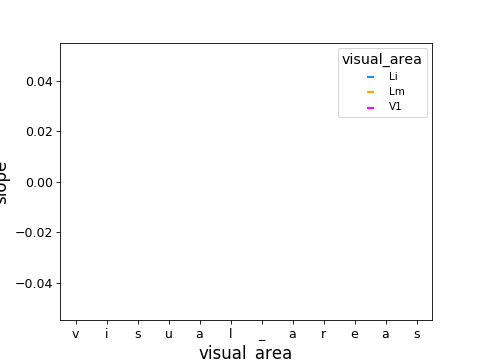

In [632]:
fig, ax = pl.subplots()
sns.pointplot(x='visual_area', y=curr_metric, data=axdf, 
              hue='visual_area', legend=False, order=visual_areas,
              ci=95, capsize=0., alpha=0.7,
              palette=area_colors, dodge=True, markers='_', join=False, ax=ax)

        

In [633]:
curr_metric

'slope'

#### Plot PW stts for SPLITs

<IPython.core.display.Javascript object>


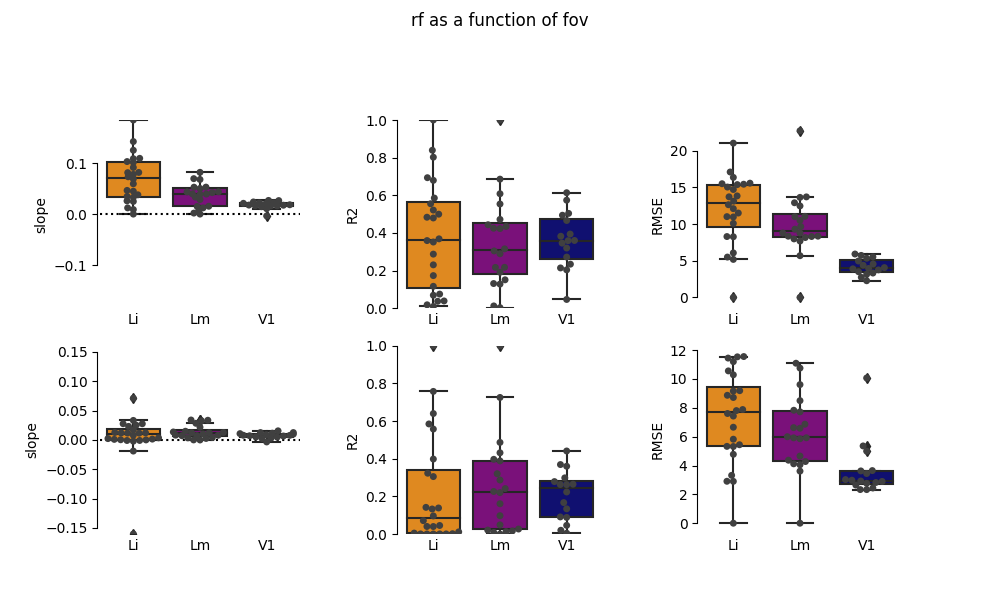

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [95]:
fig, axes = pl.subplots(2, 3, figsize=(10,6))
fig.patch.set_alpha(1)

for ai, axn in enumerate(['xpos', 'ypos']):
    curr_pwstats = pwstats_split.groupby(['axis']).get_group(axn)

    ax1 = boxplot_visual_area(curr_pwstats, metric='slope', ax=axes[ai, 0], area_colors=area_colors)

    ax2 = boxplot_visual_area(curr_pwstats, metric='R2', ax=axes[ai, 1], area_colors=area_colors)

    ax3 = boxplot_visual_area(curr_pwstats, metric='RMSE', ax=axes[ai, 2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'split-axes_stats-regr-on-%s_bmo.svg' % indep_var))

In [96]:
def boxplot_visual_area(df, metric='slope', whichax=None, ax=None, area_colors=None):
    if ax is None:
        fig, ax = pl.subplots()
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
        
    if whichax == None:
        metricname = metric
    else:
        metricname = '%s_%s' % (metric, whichax)

    df[metricname] = df[metricname].astype(float)
        
    sns.boxplot(x='visual_area', y=metricname, data=df, ax=ax, palette=area_colors)
    sns.swarmplot(x='visual_area', y=metricname, data=df, color=".25", ax=ax)
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')       
    
    if metric in ['slope', 'pearsonr']:
        ax.axhline(y=0, linestyle=':', color='k')
        
    if metric == 'pearsonr':
        ax.set_ylim([-1, 1])
    elif metric in ['pearsonr-abs', 'R2']:
        ax.set_ylim([0, 1])
    elif metric == 'slope':
        maxv = df[metricname].abs().max()
        ax.set_ylim([-maxv, maxv])
    sns.despine(trim=True, offset=2, bottom=True, ax=ax)
    
    #ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
    return ax



#### PW dists, split:  Plot slope for Az and El on same 

In [97]:
axdf.groupby(['visual_area'])['slope'].apply(np.mean)

NameError: name 'axdf' is not defined

<IPython.core.display.Javascript object>


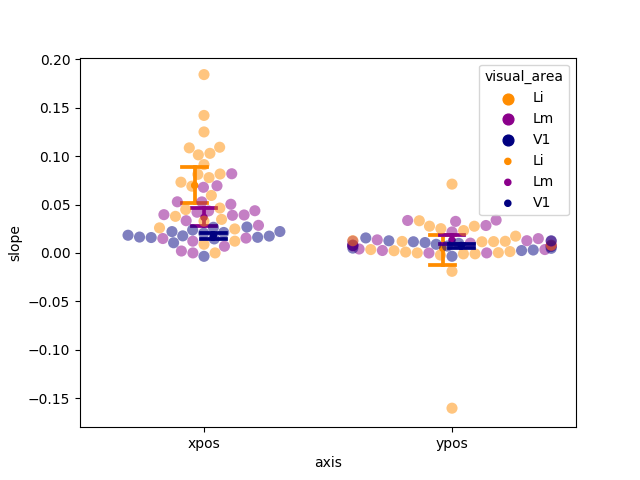

In [98]:
fig, ax = pl.subplots(1,1)
# dummy plots, just to get the Path objects
a = ax.scatter([0, 0],[0, 0], marker='s')
b = ax.scatter([0, 0],[0, 0], marker='o')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()

ax = sns.swarmplot(x="axis", y="slope", hue="visual_area",data=pwstats_split, 
                   palette=area_colors,size=8,ax=ax, dodge=False, alpha=0.5,facecolor='none')
N_hues = len(pd.unique(pwstats_split.visual_area))

c = ax.collections
for a in c[::N_hues]:
    a.set_paths([triangle_up_mk])
#update legend
ax.legend(c[-3:],pd.unique(pwstats_split.visual_area))


mvs = pwstats_split.groupby(['axis', 'visual_area']).slope.apply(np.mean)

sns.pointplot(x='axis', y='slope', hue='visual_area', data=pwstats_split, ci=95, capsize=0.1,
             palette=area_colors, dodge=True, apha=0.7, markers='.', join=False)


In [185]:
pwstats_split.groupby(['axis', 'visual_area']).slope.apply(np.mean)


axis  visual_area
xpos  Li             0.063929
      Lm             0.045119
      V1             0.016610
ypos  Li             0.009870
      Lm             0.020191
      V1             0.009434
Name: slope, dtype: float64

In [99]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0   0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1    0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2    0.554981   14.701    JC089  xpos  JC089_20190522_FOV1_zoom2p0x   
3   0.0398027  11.2011    JC089  ypos  JC089_20190522_FOV1_zoom2p0x   
4  0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   

             fov intercept   session       slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502  0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502   0.0250456          Li  
2  FOV1_zoom2p0x   1.47137  20190522   0.0815022          Li  
3  FOV1_zoom2p0x   17.3205  20190522   -0.019012          Li  
4  FOV1_zoom2p0x   13.5166  20190605   0.0121294          Li

<IPython.core.display.Javascript object>


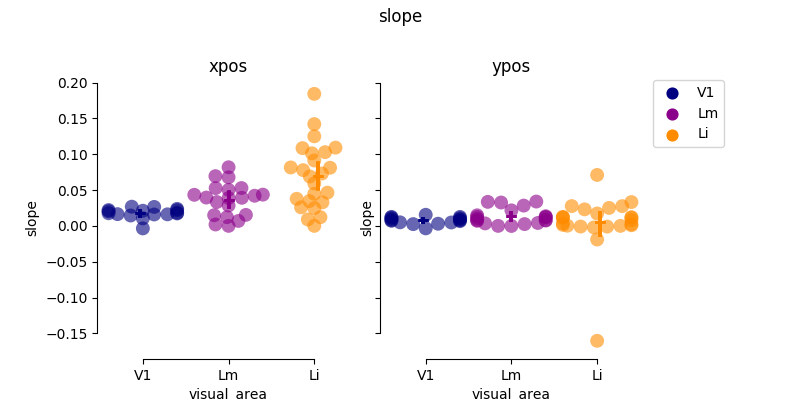

In [100]:

metric = 'slope'
fig, axes = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

for ax, axn in zip(axes.flat, ['xpos', 'ypos']):
    axdf = pwstats_split[pwstats_split['axis']==axn]
    g = sns.swarmplot(x='visual_area', y=metric, hue='visual_area', ax=ax,
                      palette=area_colors, data=axdf.sort_values(by='visual_area', ascending=False),
                     marker='o', facecolor='none', s=10,  alpha=0.6)

    for ai, visual_area in enumerate(visual_areas):
        mval =  axdf[axdf['visual_area']==visual_area][metric].mean()

       # ax.plot(ai, mval, color=area_colors[visual_area], marker='_', markersize=30)
        sns.pointplot(x='visual_area', y=metric, hue='visual_area', legend=False,
                     data=axdf.sort_values(by='visual_area', ascending=False),
                     ci=95, capsize=0., alpha=0.7,
                     palette=area_colors, dodge=True, markers='_', join=False, ax=ax)
    ax.set_title(axn)
    if axn == 'xpos':
        ax.legend_.remove()
    else:
        # Get the handles and labels. For this example it'll be 2 tuples
        # of length 4 each.
        handles, labels = ax.get_legend_handles_labels()

        # When creating the legend, only use the first two elements
        # to effectively remove the last two.
        l = pl.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine(trim=True, offset=2)
pl.subplots_adjust(wspace=0.1, right=0.8, top=0.8)
fig.suptitle(metric)

pl.savefig(os.path.join(pairwisedir, '%s_pw-dists_ax-v-el_bmo.svg' % metric))


In [141]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0    0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1     0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2   0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   
3  0.000301296  7.80888    JC090  ypos  JC090_20190605_FOV1_zoom2p0x   
4      0.17312   12.629    JC091  xpos  JC091_20190602_FOV1_zoom2p0x   

             fov intercept   session        slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502   0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502    0.0250456          Li  
2  FOV1_zoom2p0x   13.5166  20190605    0.0121294          Li  
3  FOV1_zoom2p0x   7.84417  20190605 -0.000939114          Li  
4  FOV1_zoom2p0x   6.17185  20190602    0.0463447          Li

# Combine axes: PW distance regression for each dataset for each visual area

In [79]:
indep_var

'fov'

<IPython.core.display.Javascript object>


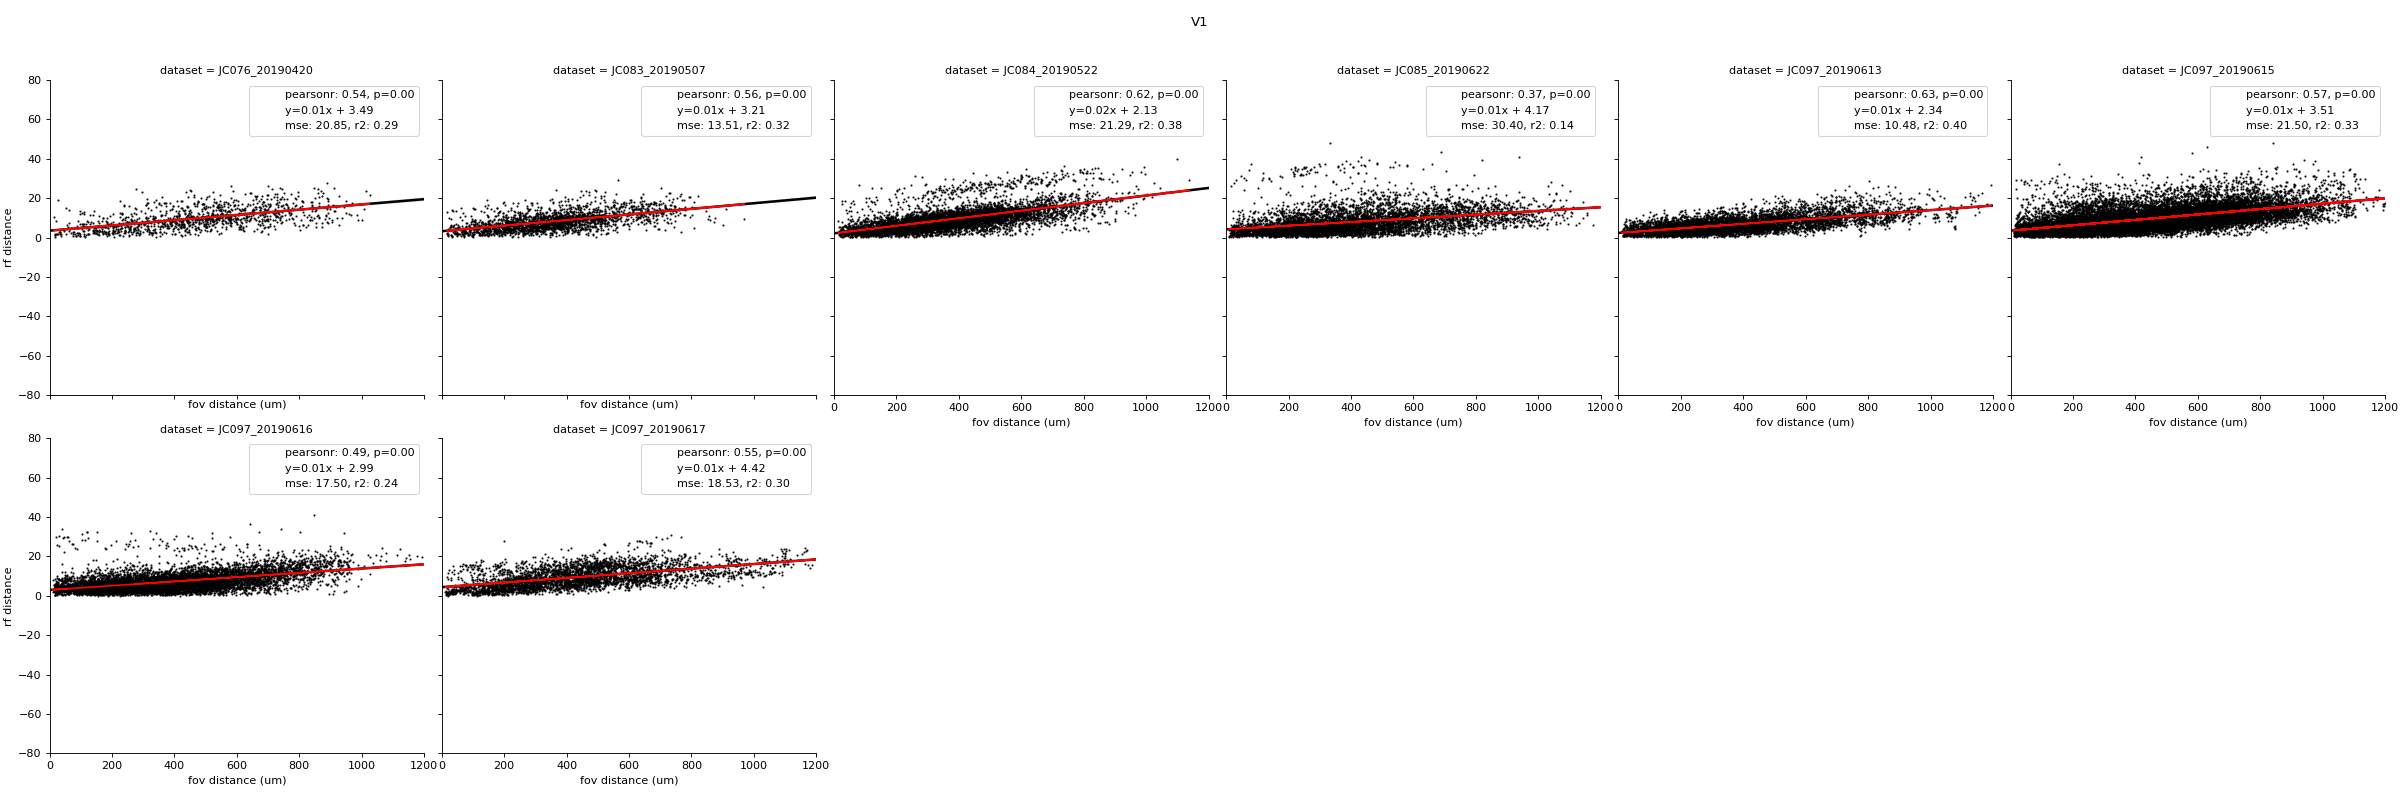

<IPython.core.display.Javascript object>


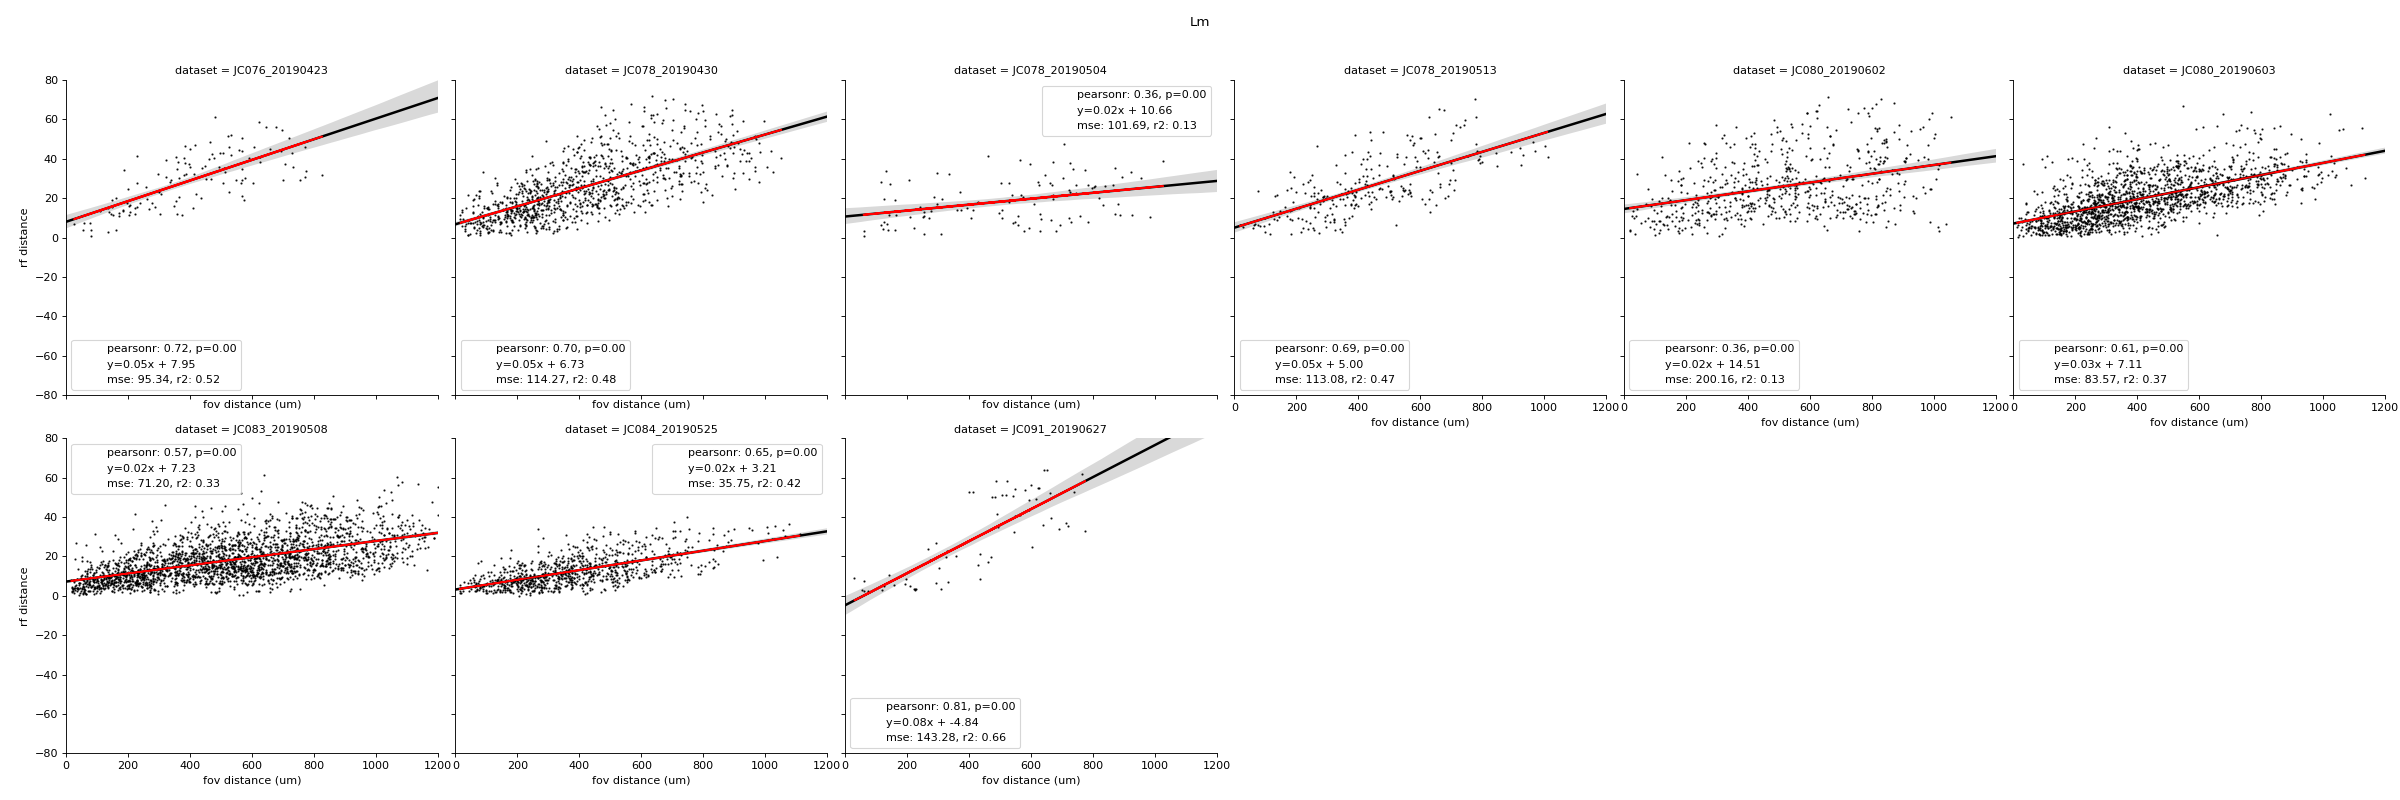

<IPython.core.display.Javascript object>


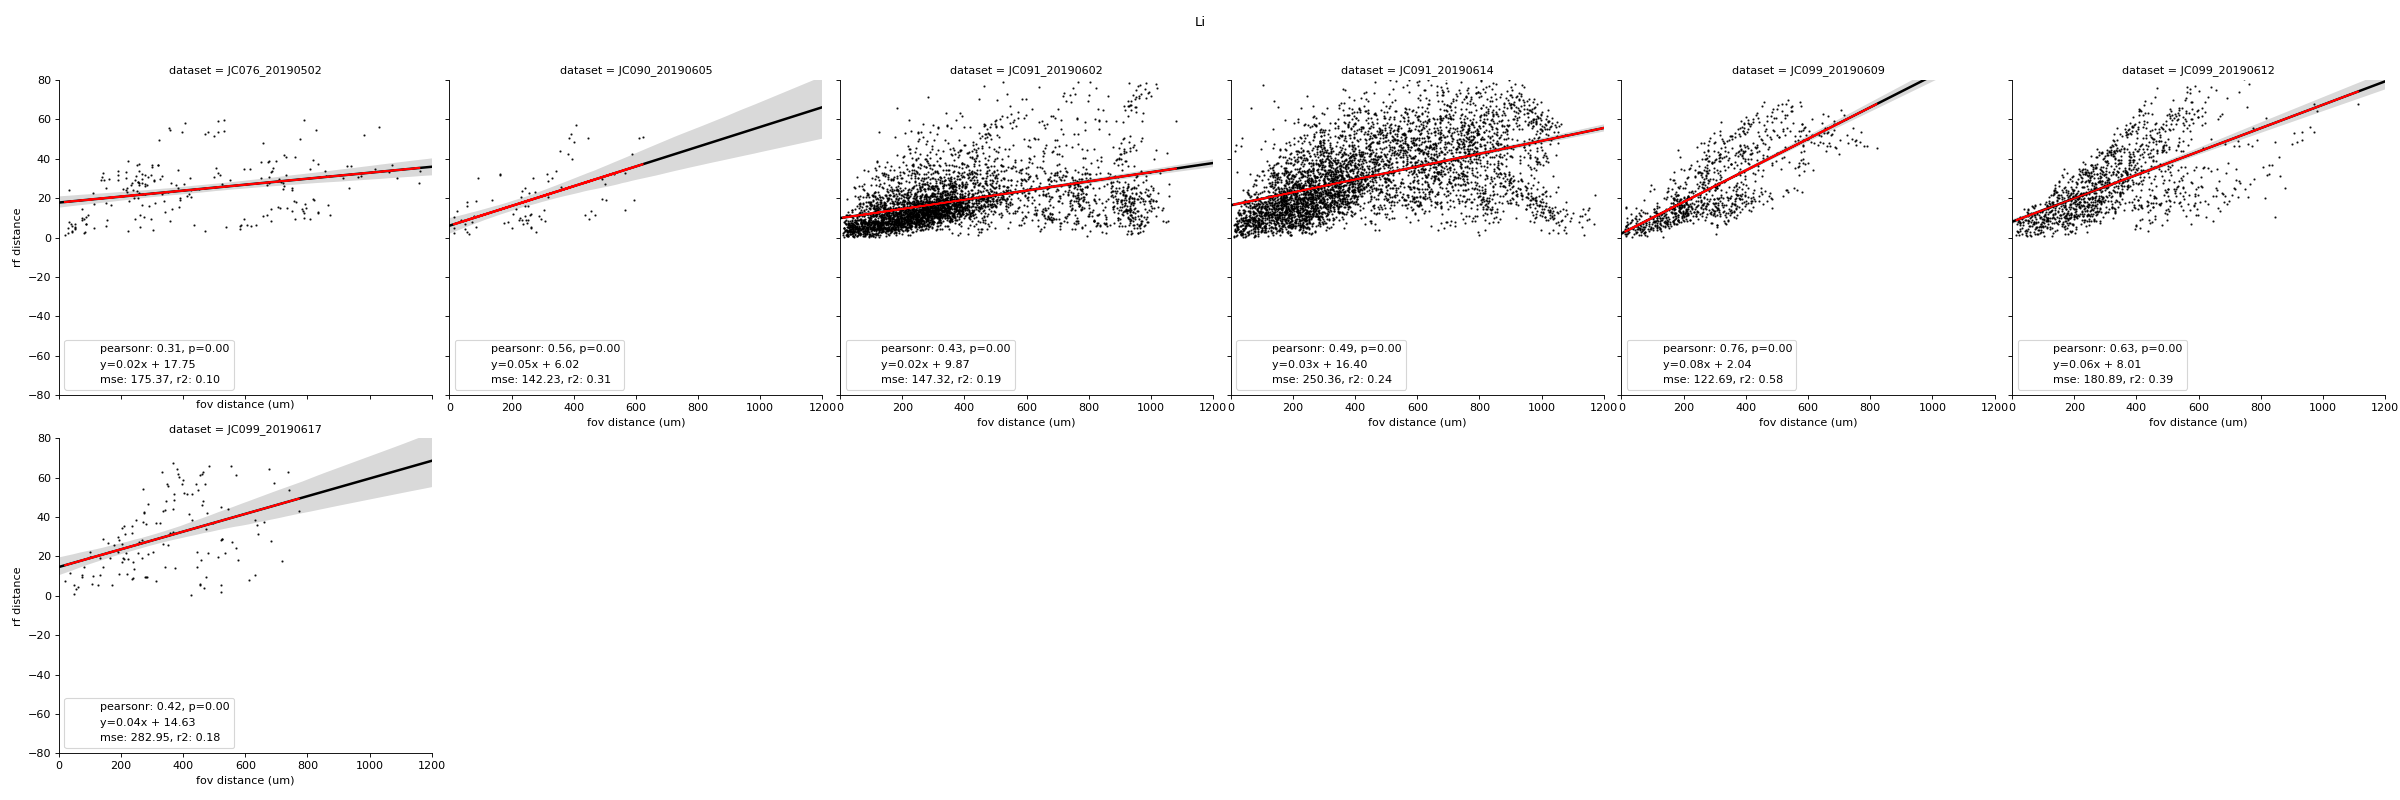

In [84]:
dep_var = 'rf' if indep_var=='fov' else 'fov'

xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200


# regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = pf[pf['visual_area']==visual_area]

    # Get all pairwise distances for each fov:
    tmpd_list = []
    for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
        cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
        rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
        tmpd = pd.DataFrame({'%s distance' % indep_var: cdists,
                            '%s distance' % dep_var: rdists,
                            'dataset': ['%s_%s' % (animalid, session) for _ in range(len(cdists))]})
        tmpd_list.append(tmpd)
    pw = pd.concat(tmpd_list, axis=0)

    # Plot regression w/ CI
    g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)

    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = pw[pw['dataset']==curr_dset]['%s distance' % indep_var]
        yv = pw[pw['dataset']==curr_dset]['%s distance' % dep_var]
        #ax.set_ylim([0, 120])
        unit = 'um' if indep_var=='fov' else 'deg'
        ax.set_xlabel('%s distance (%s)' % (indep_var, unit))

        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, 'r')
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)

        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        
#         regr_stats.append(pd.Series({'dataset': curr_dset,
#                                    'RMSE': np.sqrt(mse),
#                                    'slope': float(regr.coef_),
#                                    'intercept': float(regr.intercept_),
#                                    'R2': r2,
#                                     'visual_area': visual_area}))


    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(curr_sessiondir, 'regr-on-%s_%s.png' % (visual_area, indep_var)))


In [94]:
# reginfo = pd.concat(regr_stats, axis=1).T
# reginfo.head()

R2     RMSE         dataset intercept       slope visual_area
0  0.291849   4.5666  JC076_20190420   3.49435   0.0133151          V1
1  0.110722  6.13418  JC076_20190501   6.32593  0.00917705          V1
2  0.317121  3.67584  JC083_20190507   3.21438   0.0141987          V1
3  0.177895  5.95603  JC083_20190510     5.859   0.0142868          V1
4   0.39773  3.88048  JC083_20190511   2.64958   0.0186305          V1

In [96]:
del reginfo

In [85]:

pwstats = []
for (visual_area, animalid, session, fov), g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    # Get all pairwise distances for current fov:
    cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
    rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
    # Get linear fit:
    fitdist, regr = fit_linear_regr(cdists, rdists, return_regr=True)
    mse = skmetrics.mean_squared_error(rdists, fitdist)
    r2 = skmetrics.r2_score(rdists, fitdist)
    res = pd.Series({'visual_area': visual_area,
                         'animalid': animalid,
                         'session': session,
                         'fov': fov,
                         'RMSE': np.sqrt(mse),
                         'R2': r2,
                         'slope': float(regr.coef_),
                         'intercept': float(regr.intercept_),
                         'dataset': '_'.join([animalid, session, fov])})
    pwstats.append(res)

pwstats = pd.concat(pwstats, axis=1).T


In [86]:
pwstats.head()

R2     RMSE animalid                       dataset            fov  \
0  0.0953611  13.2428    JC076  JC076_20190502_FOV1_zoom2p0x  FOV1_zoom2p0x   
1    0.31371  11.9261    JC090  JC090_20190605_FOV1_zoom2p0x  FOV1_zoom2p0x   
2   0.186778  12.1375    JC091  JC091_20190602_FOV1_zoom2p0x  FOV1_zoom2p0x   
3   0.243542  15.8227    JC091  JC091_20190614_FOV1_zoom2p0x  FOV1_zoom2p0x   
4   0.584282  11.0767    JC099  JC099_20190609_FOV1_zoom2p0x  FOV1_zoom2p0x   

  intercept   session      slope visual_area  
0   17.7525  20190502  0.0151595          Li  
1   6.01845  20190605  0.0501515          Li  
2   9.86805  20190602  0.0233078          Li  
3   16.3973  20190614  0.0326908          Li  
4   2.04233  20190609  0.0800883          Li

<IPython.core.display.Javascript object>


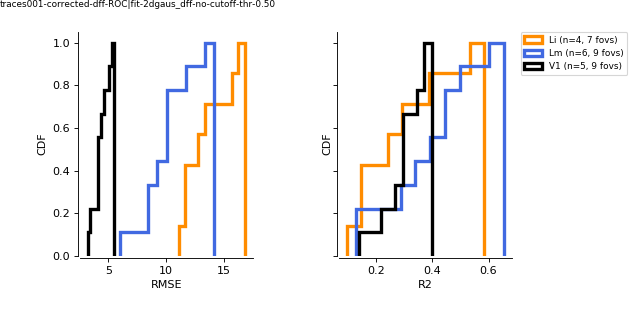

In [87]:
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in pwstats.groupby(['visual_area']):
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    values = tmpd['RMSE'].values.astype(float)
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel('RMSE')
    sns.despine(ax=ax, offset=2)
    ax.set_ylabel('CDF')
    
    
    values = tmpd['R2'].values.astype(float)
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, offset=2)
    ax.set_xlabel('R2')
    ax.set_ylabel('CDF')
    #ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(pairwisedir, 'pairwise-distances_RMSE-R2_cdf_regr-on-%s.png' % indep_var))


# Look at slope / intercept

<IPython.core.display.Javascript object>


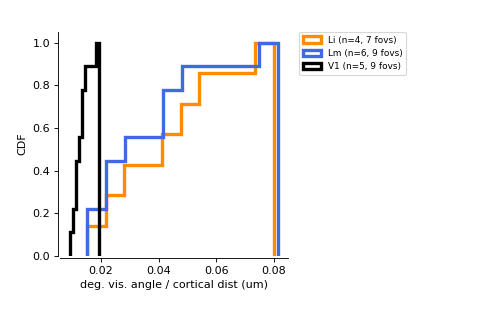

In [88]:
use_slope = True
fig, ax = pl.subplots(figsize=(6,4))

fig.patch.set_alpha(1)
for visual_area, tmpd in pwstats.groupby(['visual_area']):
    if use_slope:
        values = [s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'deg. vis. angle / cortical dist (um)'
        else:
            xlabel = 'cortical dist (um) / deg vis. angle'
    else:
        values = [1./s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'cortical dist (um) / deg vis. angle'
        else:
            xlabel = 'deg. vis. angle / cortical dist (um)'
    
    #dset_names = g['dataset'].unique()
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #ax.set_xticks([round(v, 1) for v in np.linspace(0, .1, 8)])
    #ax.set_xticklabels([round(v, 2) for v in np.linspace(0, .1, 8)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    sns.despine(trim=False, offset=2, ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

pl.savefig(os.path.join(pairwisedir, 'slopes_regr-on-%s_cdf.png' % indep_var))

<IPython.core.display.Javascript object>


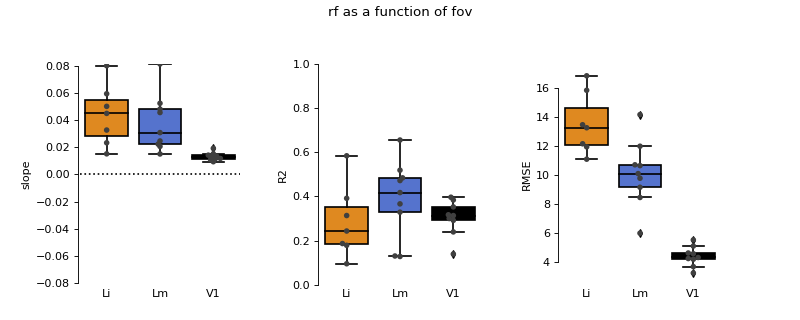

In [89]:
fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(pwstats, metric='slope', ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(pwstats, metric='R2', ax=axes[1], area_colors=area_colors)

ax3 = boxplot_visual_area(pwstats, metric='RMSE', ax=axes[2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'stats-regr-on-%s.png' % indep_var))

In [113]:
posdf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0      5    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1      7    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2     24    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3     25    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4     26    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf  
0  273.349886  5.655262  
1  125.092321  1.460737  
2  356.744767  4.182264  
3  403.075256  2.775072  
4  379.910012  2.955575

<IPython.core.display.Javascript object>


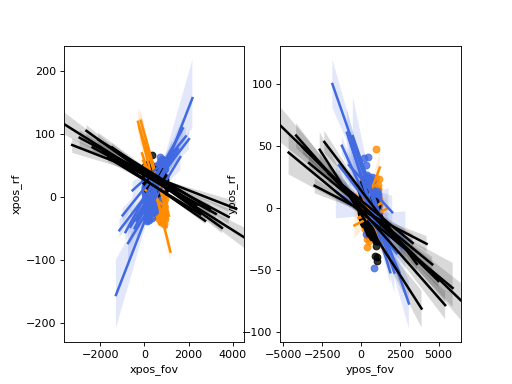

In [90]:
fig, axes = pl.subplots(1, 2)


for (visual_area, animalid, session, fov), tmpd in posdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.regplot('xpos_fov', 'xpos_rf', data=tmpd, ax=axes[0], color=area_colors[visual_area])
    sns.regplot('ypos_fov', 'ypos_rf', data=tmpd, ax=axes[1], color=area_colors[visual_area])


# Plot Center of mass for each FOV

In [101]:
df.head()

r2    sigma_x    sigma_y     theta         x0         y0 animalid  \
13  0.592816  13.408074  11.469334 -0.288729  12.200497   0.748017    JC089   
14  0.554771  19.490870  10.009762 -0.994947 -51.552794  10.413053    JC089   
15  0.512692  11.433837   5.652660 -0.673435   4.479900   0.366059    JC089   
16  0.571984  15.485803   9.977350  0.513668   8.736586   1.810410    JC089   
17  0.800984  13.283970  14.656829 -0.968406   4.725769  11.074534    JC089   

    cell              datakey experiment   session visual_area   avg_size  \
13   113  20190522_JC089_fov1      rfs10  20190522          Li  12.438704   
14    11  20190522_JC089_fov1      rfs10  20190522          Li  14.750316   
15    80  20190522_JC089_fov1      rfs10  20190522          Li   8.543248   
16   145  20190522_JC089_fov1      rfs10  20190522          Li  12.731577   
17   116  20190522_JC089_fov1      rfs10  20190522          Li  13.970399   

    datakey_ix        fx        fy  
13           1  6.426534  1.908865  
14           1  5.306854  8.173787  
15           1  4.468822  3.565500  
16           1  6.743666  3.804668  
17           1  4.152378  6.038495

In [104]:
CoMs = {}
screeninfo = {}
for (visual_area, animalid, session, fovnum), tmpd in df.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
    xpos, ypos = S.get_stimulus_coordinates()
    CoMs['%s_%s' % (animalid, session)] = (xpos, ypos) #[(xpos, ypos) for _ in range(tmpd.shape[0])])
    screenleft, screenright = S.screen['linminW'], S.screen['linmaxW']
    screenbottom, screentop = S.screen['linminH'], S.screen['linmaxH']
    screenaspect = S.screen['resolution'][0] / S.screen['resolution'][1]
    screeninfo['%s_%s' % (animalid, session)] = (screenleft, screenright, screenbottom, screentop, screenaspect) #for _ in range(tmpd.shape[0])])
    

[JC089] 20190522 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC089 | 20190522 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
[JC089|20190522] No experiment exists for: blobs
[JC089|20190522|FOV1_zoom2p0x] creating gratings object
Getting stimulus info for: combined_gratings_static


AssertionError: [gratings] more than 1 xpos found! []

In [204]:


rfdf['CoM-x'] = [CoMs['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

rfdf['CoM-y'] = [CoMs['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenleft'] = [screeninfo['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenright'] = [screeninfo['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenbottom'] = [screeninfo['%s_%s' % (animalid, session)][2] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screentop'] = [screeninfo['%s_%s' % (animalid, session)][3] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenaspect'] = [screeninfo['%s_%s' % (animalid, session)][4] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

In [205]:
rfdf[((rfdf['animalid']=='JC084') & (rfdf['session']=='20190522'))]

r2    sigma_x    sigma_y     theta         x0         y0   cell  \
0    0.734225  15.872766  23.564779  1.533098  24.776422 -11.469018    0.0   
1    0.520136  16.516020  19.051182 -0.523212  32.432005 -11.544950    2.0   
2    0.552829  18.949260  27.004408 -1.426131  17.836423 -12.234272    5.0   
3    0.852096  23.878438  19.566025 -0.027895  24.116823 -11.728018    9.0   
4    0.869807  21.945404  16.465211  0.250786  21.851019 -11.102363   11.0   
5    0.749326  24.060205  17.826767 -0.540785  21.079350 -12.622418   12.0   
6    0.855683  30.551514  22.742899 -0.194002  24.359459 -15.700910   17.0   
7    0.696656  27.990076  23.843953  0.069130  25.972457 -13.935280   18.0   
8    0.768487  21.792108  20.778926  0.133244  24.595777 -15.828255   19.0   
9    0.647991  19.231749  23.597969  7.482864  24.647061 -14.644582   20.0   
10   0.664964  28.485420  23.327092 -0.165733  22.522499 -13.689643   21.0   
11   0.697408  37.220701  20.067509 -0.538142  25.617105 -14.165844   23.0   
12   0.830778  28.052161  22.851207  0.019171  23.959988 -18.060165   25.0   
13   0.659888  24.684523  22.871740 -0.110131  25.477272 -14.224848   26.0   
14   0.706372  32.309309  21.921249 -3.626894  24.790675 -15.134649   27.0   
15   0.771317   6.238730   6.857521  2.065690  19.994226 -19.770466   29.0   
16   0.528987  13.406842  11.629828 -2.447291  27.486044 -15.949036   30.0   
17   0.838610  18.920871  15.368178 -6.821364  25.340041 -17.589140   33.0   
18   0.758682  25.043465  28.017584  0.173640  26.432311 -20.467824   35.0   
19   0.842691  17.751149  33.932036  0.535572  30.602510 -26.987631   36.0   
20   0.623137  39.765831  24.771200 -0.669511  22.286065 -18.509528   41.0   
21   0.618670  35.668650  19.654706 -0.137295  20.236856 -13.920210   43.0   
22   0.580811  15.462046  12.018522  1.919947  21.389652 -17.079508   46.0   
23   0.802064  27.752021  20.591647 -0.668535  20.685405 -13.793877   51.0   
24   0.871361  14.736783  11.827486 -0.605707  20.827247 -19.105224   55.0   
25   0.922144  17.177681  26.224431  0.493811  21.744589 -22.958313   56.0   
26   0.871618  16.521106  23.569554  0.764062  22.413474 -18.922926   57.0   
27   0.891020  14.663139  17.637268  1.201600  24.708676 -18.084358   61.0   
28   0.686160  21.183891  16.435022 -0.022699  20.866747 -21.480730   63.0   
29   0.844889  22.705430  32.684764  0.442448  23.979186 -21.983852   65.0   
..        ...        ...        ...       ...        ...        ...    ...   
81   0.721882  20.436226  27.460882 -0.427208  11.284117 -23.986294  171.0   
82   0.635870  25.878303  24.444987 -0.434986  10.510104 -20.072448  174.0   
83   0.813350  22.483890  18.742877  0.397909  11.166434 -18.448552  175.0   
84   0.865164  26.305847  31.387653  0.166666  11.483976 -18.466111  177.0   
85   0.849957  18.340392  30.809925  0.294362  15.497146 -21.477660  179.0   
86   0.693269  26.096302  35.645822  0.755536  16.707170 -20.983488  184.0   
87   0.781412  27.342184  39.406041  0.147644  12.491562 -30.599855  188.0   
88   0.582609  20.290799  24.464417 -0.417452   9.750868 -24.421227  189.0   
89   0.782352  20.881153  25.918258  0.259672  12.556678 -18.171527  190.0   
90   0.835715  14.808048  10.128542  0.177550  14.062034 -13.210156  191.0   
91   0.794471  18.984261  22.412270  0.314406  14.864463 -15.403845  193.0   
92   0.562086  32.455780  21.475909  0.154162  23.113591 -11.583298  194.0   
93   0.813154  27.714355  20.883445 -0.044016  16.923544  -9.058432  203.0   
94   0.606997  29.982173  21.429867  2.886234  13.142431 -11.571851  205.0   
95   0.782076  18.206397  14.606948 -3.506632  14.061718 -10.883947  210.0   
96   0.620140  22.385888  14.165443 -0.340382  14.972889 -10.682200  212.0   
97   0.530217  27.988678  21.714117  0.250591  15.421748 -13.415667  215.0   
98   0.750720  32.446550  29.802162 -0.214508  15.885883 -13.517998  216.0   
99   0.524750  32.493424  14.750089 -0.098812   7.807519  -8.524383  223.0   
100  0.700816  24.475980  21.8589

In [173]:
assert len(rfdf['screenleft'].unique())==1
assert len(rfdf['screenright'].unique())==1
assert len(rfdf['screentop'].unique())==1
assert len(rfdf['screenbottom'].unique())==1

In [170]:
screenleft = float(rfdf['screenleft'].unique())
screenright = float(rfdf['screenright'].unique())
screenbottom = float(rfdf['screenbottom'].unique())
screentop = float(rfdf['screentop'].unique())

In [247]:
all_cell_counts = rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']).count()['r2'].values
max_ncells = all_cell_counts.max()

ncells_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in all_cell_counts]
#ncells_alphas

[0.09502262443438914,
 0.058823529411764705,
 0.6244343891402715,
 0.2171945701357466,
 0.33031674208144796,
 0.43891402714932126,
 0.19909502262443438,
 0.23076923076923078,
 0.07692307692307693,
 0.07239819004524888,
 0.4117647058823529,
 0.20361990950226244,
 0.06787330316742081,
 0.06334841628959276,
 0.10407239819004525,
 0.14027149321266968,
 0.16289592760180996,
 0.26244343891402716,
 0.3167420814479638,
 0.248868778280543,
 0.09954751131221719,
 0.19004524886877827,
 0.05429864253393665,
 0.2171945701357466,
 0.07692307692307693,
 0.2986425339366516,
 0.17194570135746606,
 0.2171945701357466,
 0.502262443438914,
 0.8823529411764706,
 0.8190045248868778,
 0.6470588235294118,
 0.5610859728506787,
 1.0,
 0.38461538461538464]

In [250]:
import matplotlib.colors as mplc

In [255]:
[mplc.to_rgba(area_colors[visual_area], alpha=c) for c in cell_alphas]

[(1.0, 0.5490196078431373, 0.0, 0.09502262443438914),
 (1.0, 0.5490196078431373, 0.0, 0.058823529411764705),
 (1.0, 0.5490196078431373, 0.0, 0.6244343891402715),
 (1.0, 0.5490196078431373, 0.0, 0.2171945701357466),
 (1.0, 0.5490196078431373, 0.0, 0.33031674208144796),
 (1.0, 0.5490196078431373, 0.0, 0.43891402714932126),
 (1.0, 0.5490196078431373, 0.0, 0.19909502262443438),
 (1.0, 0.5490196078431373, 0.0, 0.23076923076923078),
 (1.0, 0.5490196078431373, 0.0, 0.07692307692307693)]

<IPython.core.display.Javascript object>


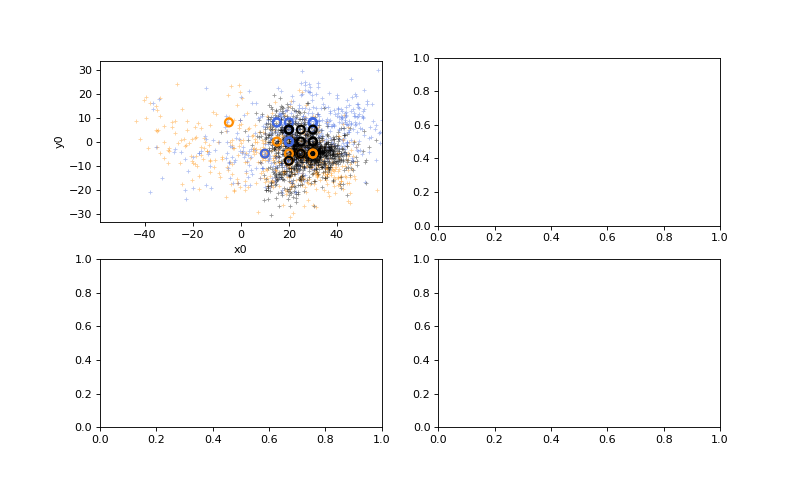

In [303]:
n_cells = []

fig, axes = pl.subplots(2, 2, figsize=(10,6))
ax = axes[0,0]
for (visual_area, animalid, session, fov), tmpd in rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.scatterplot('x0', 'y0', data=tmpd, ax=ax, color=area_colors[visual_area],
                   s=10, marker='+', alpha=0.4, edgecolor=area_colors[visual_area])
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)

    n_cells.append(tmpd.shape[0])

ax = axes[0,0]
for visual_area, tmpd in rfdf.groupby(['visual_area']):
    xcoms = [float(g['CoM-x'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ycoms = [float(g['CoM-y'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ncells = np.array([g.shape[0] for k, g in tmpd.groupby(['animalid', 'session', 'fov'])])
    cell_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in ncells]

    rgba_colors = [mplc.to_rgba(area_colors[visual_area], alpha=c/4.) for c in cell_alphas]
    
    ax.scatter(xcoms, ycoms, s=50, lw=2, edgecolors=area_colors[visual_area], alpha=1, facecolor='none') #c=rgba_colors, 
    #ax.scatter(xcoms, ycoms, s=ncells, c=rgba_colors)

    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)


In [232]:
ncells

[48, 17, 66, 38, 48, 111, 195, 181, 143, 124, 221, 85]